In [ ]:
!pip install librosa numpy scikit-learn matplotlib soundfile audioread

### (ZCR + SC + SR + MFCC) * (Mean + Variance)

- 類別 : ['blues', 'classical', 'jazz', 'pop', 'rock']
- 樣本數 : 每類各 100 筆，共 499 筆 (jazz 有 1 筆檔案毀損)
- 特徵長度 : 1s
- 切割重疊時長 : 0.5s
- 蒙地卡羅次數 : 5
- 訓練集:測試集 = 8:2

In [4]:
import os
import librosa
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import collections

# --- 參數設定 ---
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']

texture_window = 1.0
overlap = 0.5
n_splits = 5

# --- 特徵提取函數 ---
def extract_features_from_segment(y_segment, sr):
    zcr = librosa.feature.zero_crossing_rate(y=y_segment)[0]
    centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)[0]
    mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
    return np.hstack([
        np.mean(zcr), np.var(zcr),
        np.mean(centroid), np.var(centroid),
        np.mean(rolloff), np.var(rolloff),
        np.mean(mfcc, axis=1), np.var(mfcc, axis=1),

    ])

def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1 - overlap))
    features = []
    for start in range(0, len(y) - texture_samples, hop_samples):
        segment = y[start:start + texture_samples]
        features.append(extract_features_from_segment(segment, sr))
    return np.array(features)

# --- 計算眾數函數 ---
def most_common_label(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

# --- 收集檔案路徑與標籤 ---
all_files = []
all_labels = []
genre_counts = {}
for genre in genres:
    genre_path = os.path.join(DATASET_PATH, genre)
    files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.wav')]
    all_files.extend(files)
    all_labels.extend([genre]*len(files))
    genre_counts[genre] = len(files)

all_files = np.array(all_files)
all_labels = np.array(all_labels)

print("=== Dataset summary ===")
for genre, count in genre_counts.items():
    print(f"{genre}: {count} files")
print(f"Total files: {len(all_files)}\n")

# --- K-fold 交叉驗證 ---
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
fold = 1
acc_scores = []

for train_index, test_index in skf.split(all_files, all_labels):
    print(f"\n=== Fold {fold} / {n_splits} ===")
    
    # 訓練集
    train_features, train_labels = [], []
    train_slice_count = 0
    train_song_count = len(train_index)
    print(f"Train songs: {train_song_count}")
    for i in tqdm(train_index, desc="Processing training songs"):
        fpath = all_files[i]
        genre = all_labels[i]
        texture_features = process_audio_file(fpath)
        train_slice_count += len(texture_features)
        train_features.extend(texture_features)
        train_labels.extend([genre]*len(texture_features))
    print(f"Total training slices: {train_slice_count}")
    print(f"Training feature matrix shape: {np.array(train_features).shape}")
    
    # 標準化
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_features)
    y_train = np.array(train_labels)
    
    # 訓練模型
    model = SVC(kernel='rbf', C=10, gamma='scale')
    model.fit(X_train, y_train)
    
    # 測試集
    test_features_count = 0
    test_preds, test_true = [], []
    test_song_count = len(test_index)
    print(f"Test songs: {test_song_count}")
    for i in tqdm(test_index, desc="Processing test songs"):
        fpath = all_files[i]
        genre = all_labels[i]
        texture_features = process_audio_file(fpath)
        test_features_count += len(texture_features)
        texture_features = scaler.transform(texture_features)
        preds = model.predict(texture_features)
        test_preds.append(most_common_label(preds))
        test_true.append(genre)
    print(f"Total test slices: {test_features_count}")
    
    # 計算準確率
    acc = accuracy_score(test_true, test_preds)
    acc_scores.append(acc)
    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(test_true, test_preds))
    print("Classification Report:")
    print(classification_report(test_true, test_preds))
    
    fold += 1

# --- 總體結果 ---
print("\n=== Cross-validation summary ===")
print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
print(f"Std Accuracy: {np.std(acc_scores):.4f}")


=== Dataset summary ===
blues: 100 files
classical: 100 files
jazz: 99 files
pop: 100 files
rock: 100 files
Total files: 499


=== Fold 1 / 5 ===
Train songs: 399


Processing training songs: 100%|██████████| 399/399 [01:43<00:00,  3.84it/s]


Total training slices: 23539
Training feature matrix shape: (23539, 32)
Test songs: 100


Processing test songs: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


Total test slices: 5898
Fold 1 Accuracy: 0.9600
Confusion Matrix:
[[19  0  0  0  1]
 [ 0 20  0  0  0]
 [ 0  0 20  0  0]
 [ 0  0  0 19  1]
 [ 1  0  0  1 18]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.95      0.95      0.95        20
   classical       1.00      1.00      1.00        20
        jazz       1.00      1.00      1.00        20
         pop       0.95      0.95      0.95        20
        rock       0.90      0.90      0.90        20

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100


=== Fold 2 / 5 ===
Train songs: 399


Processing training songs: 100%|██████████| 399/399 [01:43<00:00,  3.84it/s]


Total training slices: 23537
Training feature matrix shape: (23537, 32)
Test songs: 100


Processing test songs: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


Total test slices: 5900
Fold 2 Accuracy: 0.9100
Confusion Matrix:
[[20  0  0  0  0]
 [ 0 19  0  0  1]
 [ 0  2 18  0  0]
 [ 0  1  0 18  1]
 [ 1  0  2  1 16]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.95      1.00      0.98        20
   classical       0.86      0.95      0.90        20
        jazz       0.90      0.90      0.90        20
         pop       0.95      0.90      0.92        20
        rock       0.89      0.80      0.84        20

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100


=== Fold 3 / 5 ===
Train songs: 399


Processing training songs: 100%|██████████| 399/399 [01:44<00:00,  3.82it/s]


Total training slices: 23537
Training feature matrix shape: (23537, 32)
Test songs: 100


Processing test songs: 100%|██████████| 100/100 [00:27<00:00,  3.57it/s]


Total test slices: 5900
Fold 3 Accuracy: 0.8800
Confusion Matrix:
[[19  0  1  0  0]
 [ 0 20  0  0  0]
 [ 2  2 15  0  1]
 [ 0  0  1 18  1]
 [ 1  0  1  2 16]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.86      0.95      0.90        20
   classical       0.91      1.00      0.95        20
        jazz       0.83      0.75      0.79        20
         pop       0.90      0.90      0.90        20
        rock       0.89      0.80      0.84        20

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100


=== Fold 4 / 5 ===
Train songs: 399


Processing training songs: 100%|██████████| 399/399 [01:43<00:00,  3.85it/s]


Total training slices: 23538
Training feature matrix shape: (23538, 32)
Test songs: 100


Processing test songs: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


Total test slices: 5899
Fold 4 Accuracy: 0.9400
Confusion Matrix:
[[19  0  0  0  1]
 [ 0 20  0  0  0]
 [ 1  0 19  0  0]
 [ 0  0  0 18  2]
 [ 0  0  0  2 18]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.95      0.95      0.95        20
   classical       1.00      1.00      1.00        20
        jazz       1.00      0.95      0.97        20
         pop       0.90      0.90      0.90        20
        rock       0.86      0.90      0.88        20

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100


=== Fold 5 / 5 ===
Train songs: 400


Processing training songs: 100%|██████████| 400/400 [01:44<00:00,  3.83it/s]


Total training slices: 23597
Training feature matrix shape: (23597, 32)
Test songs: 99


Processing test songs: 100%|██████████| 99/99 [00:27<00:00,  3.56it/s]

Total test slices: 5840
Fold 5 Accuracy: 0.8687
Confusion Matrix:
[[16  0  1  0  3]
 [ 0 20  0  0  0]
 [ 1  2 16  0  0]
 [ 0  0  0 19  1]
 [ 1  0  1  3 15]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.89      0.80      0.84        20
   classical       0.91      1.00      0.95        20
        jazz       0.89      0.84      0.86        19
         pop       0.86      0.95      0.90        20
        rock       0.79      0.75      0.77        20

    accuracy                           0.87        99
   macro avg       0.87      0.87      0.87        99
weighted avg       0.87      0.87      0.87        99


=== Cross-validation summary ===
Mean Accuracy: 0.9117
Std Accuracy: 0.0346


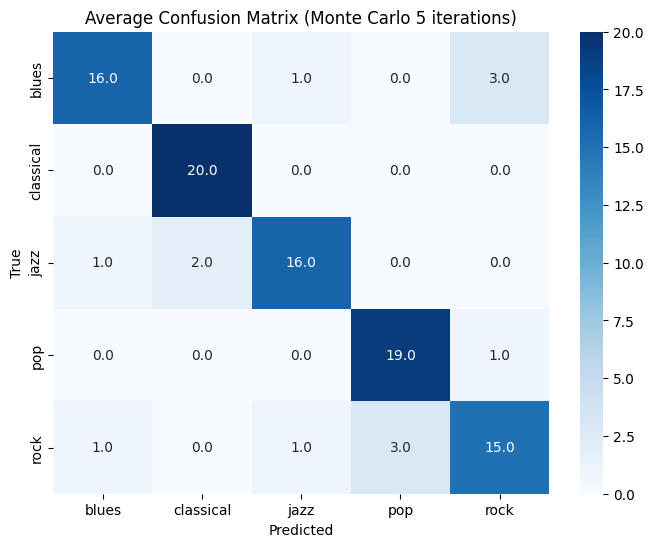

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 假設有五次迭代的結果
all_conf_matrices = []

for iteration in range(5):
    # test_true, test_preds 為該次迭代的真實標籤與預測標籤
    cm = confusion_matrix(test_true, test_preds, labels=genres)
    all_conf_matrices.append(cm)

# 計算平均混淆矩陣
avg_cm = np.mean(all_conf_matrices, axis=0)

plt.figure(figsize=(8,6))
sns.heatmap(avg_cm, annot=True, fmt=".1f", xticklabels=genres, yticklabels=genres, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Average Confusion Matrix (Monte Carlo 5 iterations)")
plt.show()


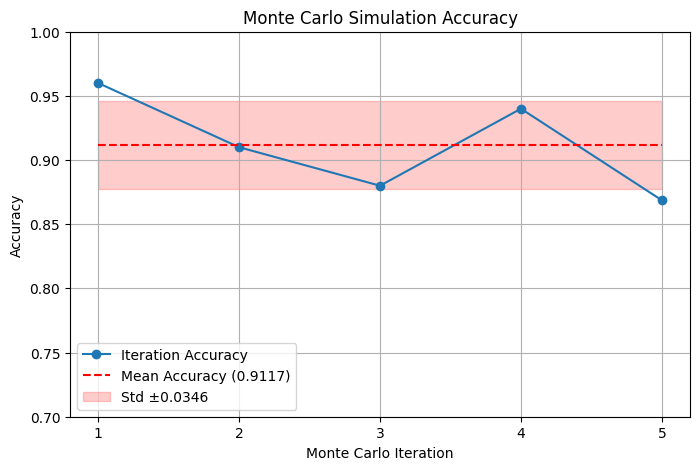

In [12]:
import matplotlib.pyplot as plt

# 假設 acc_scores 已經有五次蒙地卡羅結果
# acc_scores = [0.82, 0.85, 0.80, 0.83, 0.81]

iterations = np.arange(1, len(acc_scores)+1)

mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)

plt.figure(figsize=(8,5))
plt.plot(iterations, acc_scores, marker='o', linestyle='-', label='Iteration Accuracy')
plt.hlines(mean_acc, 1, len(acc_scores), colors='r', linestyles='dashed', label=f'Mean Accuracy ({mean_acc:.4f})')
plt.fill_between(iterations, mean_acc-std_acc, mean_acc+std_acc, color='r', alpha=0.2, label=f'Std ±{std_acc:.4f}')

plt.xticks(iterations)
plt.ylim(0.7, 1)
plt.xlabel("Monte Carlo Iteration")
plt.ylabel("Accuracy")
plt.title("Monte Carlo Simulation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### (ZCR + SC + SR + MFCC + Chroma) * (Mean + Variance)

- 類別 : ['blues', 'classical', 'jazz', 'pop', 'rock']
- 樣本數 : 每類各 100 筆，共 499 筆 (jazz 有 1 筆檔案毀損)
- 特徵長度 : 1s
- 切割重疊時長 : 0.5s
- 蒙地卡羅次數 : 5
- 訓練集:測試集 = 8:2

In [13]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm

# --- 參數設定 ---
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']

texture_window = 1.0
overlap = 0.5
n_iterations = 5
test_size = 0.2

# --- 特徵提取函數 ---
def extract_features_from_segment(y_segment, sr):
    zcr = librosa.feature.zero_crossing_rate(y=y_segment)[0]
    centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)[0]
    mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y_segment, sr=sr)
    return np.hstack([
        np.mean(zcr), np.var(zcr),
        np.mean(centroid), np.var(centroid),
        np.mean(rolloff), np.var(rolloff),
        np.mean(mfcc, axis=1), np.var(mfcc, axis=1),
        np.mean(chroma, axis=1), np.var(chroma, axis=1)
    ])

def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1 - overlap))
    features = []
    for start in range(0, len(y) - texture_samples, hop_samples):
        segment = y[start:start + texture_samples]
        features.append(extract_features_from_segment(segment, sr))
    return np.array(features)

def most_common_label(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

# --- 收集檔案與標籤 ---
all_files = []
all_labels = []
for genre in genres:
    genre_path = os.path.join(DATASET_PATH, genre)
    files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.wav')]
    all_files.extend(files)
    all_labels.extend([genre]*len(files))

all_files = np.array(all_files)
all_labels = np.array(all_labels)

print(f"Total files: {len(all_files)}")

# --- 蒙地卡羅模擬 ---
acc_scores = []

for iteration in range(1, n_iterations+1):
    print(f"\n=== Monte Carlo Iteration {iteration} ===")
    
    train_files, test_files, train_labels, test_labels = train_test_split(
        all_files, all_labels, test_size=test_size, stratify=all_labels, random_state=iteration
    )
    
    # --- 訓練特徵 ---
    train_features, train_y = [], []
    for fpath, label in tqdm(zip(train_files, train_labels), total=len(train_files), desc="Processing training files"):
        feats = process_audio_file(fpath)
        train_features.extend(feats)
        train_y.extend([label]*len(feats))
        
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_features)
    y_train = np.array(train_y)
    
    # --- 訓練羅吉斯迴歸模型 ---
    model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
    model.fit(X_train, y_train)
    
    # --- 測試特徵 ---
    test_preds, test_true = [], []
    for fpath, label in tqdm(zip(test_files, test_labels), total=len(test_files), desc="Processing test files"):
        feats = process_audio_file(fpath)
        feats = scaler.transform(feats)
        preds = model.predict(feats)
        test_preds.append(most_common_label(preds))
        test_true.append(label)
    
    acc = accuracy_score(test_true, test_preds)
    acc_scores.append(acc)
    
    print(f"Iteration {iteration} Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(test_true, test_preds))
    print("Classification Report:")
    print(classification_report(test_true, test_preds))

# --- 總體結果 ---
print("\n=== Monte Carlo Summary ===")
print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
print(f"Std Accuracy: {np.std(acc_scores):.4f}")


Total files: 499

=== Monte Carlo Iteration 1 ===


Processing training files:  22%|██▏       | 86/399 [00:35<02:06,  2.47it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing training files: 100%|██████████| 399/399 [19:53<00:00,  2.99s/it]
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
Processing test files: 100%|██████████| 100/100 [07:29<00:00,  4.50s/it]


Iteration 1 Accuracy: 0.8500
Confusion Matrix:
[[18  0  2  0  0]
 [ 0 19  1  0  0]
 [ 1  1 17  0  1]
 [ 0  0  0 18  2]
 [ 4  0  2  1 13]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.78      0.90      0.84        20
   classical       0.95      0.95      0.95        20
        jazz       0.77      0.85      0.81        20
         pop       0.95      0.90      0.92        20
        rock       0.81      0.65      0.72        20

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100


=== Monte Carlo Iteration 2 ===


Processing training files:  32%|███▏      | 129/399 [18:03<01:45,  2.55it/s]   c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing training files: 100%|██████████| 399/399 [19:49<00:00,  2.98s/it]
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
Processing test files: 100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Iteration 2 Accuracy: 0.8400
Confusion Matrix:
[[19  0  0  0  1]
 [ 0 20  0  0  0]
 [ 1  1 16  0  2]
 [ 1  1  0 14  4]
 [ 4  0  0  1 15]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.76      0.95      0.84        20
   classical       0.91      1.00      0.95        20
        jazz       1.00      0.80      0.89        20
         pop       0.93      0.70      0.80        20
        rock       0.68      0.75      0.71        20

    accuracy                           0.84       100
   macro avg       0.86      0.84      0.84       100
weighted avg       0.86      0.84      0.84       100


=== Monte Carlo Iteration 3 ===


Processing training files:   6%|▋         | 25/399 [00:10<02:34,  2.42it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing training files: 100%|██████████| 399/399 [05:48<00:00,  1.14it/s]
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
Processing test files:  87%|████████▋ | 87/100 [00:45<00:06,  1.92it/s]


KeyboardInterrupt: 

### (ZCR + SC + SR) * (Mean + Variance)

- 類別 : ['blues', 'classical', 'jazz', 'pop', 'rock']
- 樣本數 : 每類各 100 筆，共 499 筆 (jazz 有 1 筆檔案毀損)
- 特徵長度 : 1s
- 切割重疊時長 : 0.5s
- 蒙地卡羅次數 : 5
- 訓練集:測試集 = 8:2

In [1]:
import os
import platform
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
from multiprocessing import cpu_count

# --- 平行運算選擇 ---
if platform.system() == "Windows":
    from multiprocessing.dummy import Pool  # Windows 多執行緒
else:
    from multiprocessing import Pool        # Linux/macOS 多進程

# --- 參數設定 ---
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']

texture_window = 1.0
overlap = 0.5
n_iterations = 5
test_size = 0.2

# === 特徵提取函數 ===
def extract_features_from_segment(y_segment, sr):
    zcr = librosa.feature.zero_crossing_rate(y=y_segment)[0]
    centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)[0]
    #mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
    #chroma = librosa.feature.chroma_stft(y=y_segment, sr=sr)
    return np.hstack([
        np.mean(zcr), np.var(zcr),
        np.mean(centroid), np.var(centroid),
        np.mean(rolloff), np.var(rolloff),
        #np.mean(mfcc, axis=1), np.var(mfcc, axis=1),
        #np.mean(chroma, axis=1), np.var(chroma, axis=1)
    ])

def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1 - overlap))
    features = []
    for start in range(0, len(y) - texture_samples, hop_samples):
        segment = y[start:start + texture_samples]
        features.append(extract_features_from_segment(segment, sr))
    return np.array(features)

def parallel_feature_extraction(file_label_pairs):
    features, labels = [], []
    for file_path, label in file_label_pairs:
        feats = process_audio_file(file_path)
        for f in feats:
            features.append(f)
            labels.append(label)
    return features, labels

def most_common_label(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

if __name__ == "__main__":
    # --- 預熱 librosa / numba ---
    _ = librosa.hz_to_note(440.0)

    # --- 收集資料集 ---
    all_files, all_labels = [], []
    for genre in genres:
        genre_path = os.path.join(DATASET_PATH, genre)
        files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.wav')]
        all_files.extend(files)
        all_labels.extend([genre] * len(files))

    all_files = np.array(all_files)
    all_labels = np.array(all_labels)
    print(f"Total files: {len(all_files)}")

    acc_scores = []

    # === Monte Carlo 模擬 ===
    for iteration in range(1, n_iterations + 1):
        print(f"\n=== Monte Carlo Iteration {iteration} ===")

        train_files, test_files, train_labels, test_labels = train_test_split(
            all_files, all_labels, test_size=test_size, stratify=all_labels, random_state=iteration
        )

        chunk_size = 5
        train_pairs = list(zip(train_files, train_labels))
        print(f"使用 {cpu_count()} 核心平行提取訓練特徵中...")
        with Pool(processes=cpu_count()) as pool:
            results = list(tqdm(
                pool.imap_unordered(parallel_feature_extraction,
                                    [train_pairs[i:i + chunk_size] for i in range(0, len(train_pairs), chunk_size)]),
                total=max(1, len(train_pairs) // chunk_size)
            ))
        train_features, train_y = [], []
        for f, l in results:
            train_features.extend(f)
            train_y.extend(l)

        # --- 標準化 + 模型訓練 ---
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_features)
        y_train = np.array(train_y)

        model = LogisticRegression(max_iter=1000, solver='lbfgs')
        model.fit(X_train, y_train)

        # --- 測試集以「每首歌投票」方式分類 ---
        test_preds, test_true = [], []
        for fpath, label in tqdm(zip(test_files, test_labels), total=len(test_files), desc="Processing test files"):
            feats = process_audio_file(fpath)
            feats = scaler.transform(feats)
            segment_preds = model.predict(feats)
            song_pred = most_common_label(segment_preds)  # 投票決定整首歌的分類
            test_preds.append(song_pred)
            test_true.append(label)

        acc = accuracy_score(test_true, test_preds)
        acc_scores.append(acc)

        print(f"Iteration {iteration} Accuracy: {acc:.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(test_true, test_preds))
        print("Classification Report:")
        print(classification_report(test_true, test_preds))

    print("\n=== Monte Carlo Summary ===")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Std Accuracy: {np.std(acc_scores):.4f}")


Total files: 499

=== Monte Carlo Iteration 1 ===
使用 20 核心平行提取訓練特徵中...


80it [01:05,  1.22it/s]                        
Processing test files: 100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


Iteration 1 Accuracy: 0.6500
Confusion Matrix:
[[ 9  1  4  0  6]
 [ 0 20  0  0  0]
 [ 2  3  8  5  2]
 [ 0  0  1 18  1]
 [ 1  2  3  4 10]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.75      0.45      0.56        20
   classical       0.77      1.00      0.87        20
        jazz       0.50      0.40      0.44        20
         pop       0.67      0.90      0.77        20
        rock       0.53      0.50      0.51        20

    accuracy                           0.65       100
   macro avg       0.64      0.65      0.63       100
weighted avg       0.64      0.65      0.63       100


=== Monte Carlo Iteration 2 ===
使用 20 核心平行提取訓練特徵中...


80it [01:05,  1.22it/s]                        
Processing test files: 100%|██████████| 100/100 [00:13<00:00,  7.44it/s]


Iteration 2 Accuracy: 0.5700
Confusion Matrix:
[[ 6  3  7  0  4]
 [ 0 19  1  0  0]
 [ 3  3  8  5  1]
 [ 0  0  3 13  4]
 [ 6  2  0  1 11]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.40      0.30      0.34        20
   classical       0.70      0.95      0.81        20
        jazz       0.42      0.40      0.41        20
         pop       0.68      0.65      0.67        20
        rock       0.55      0.55      0.55        20

    accuracy                           0.57       100
   macro avg       0.55      0.57      0.56       100
weighted avg       0.55      0.57      0.56       100


=== Monte Carlo Iteration 3 ===
使用 20 核心平行提取訓練特徵中...


80it [01:05,  1.23it/s]                        
Processing test files: 100%|██████████| 100/100 [00:13<00:00,  7.68it/s]


Iteration 3 Accuracy: 0.5600
Confusion Matrix:
[[ 4  6  7  0  3]
 [ 0 19  0  0  1]
 [ 4  5  8  1  2]
 [ 0  0  4 14  2]
 [ 3  3  1  2 11]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.36      0.20      0.26        20
   classical       0.58      0.95      0.72        20
        jazz       0.40      0.40      0.40        20
         pop       0.82      0.70      0.76        20
        rock       0.58      0.55      0.56        20

    accuracy                           0.56       100
   macro avg       0.55      0.56      0.54       100
weighted avg       0.55      0.56      0.54       100


=== Monte Carlo Iteration 4 ===
使用 20 核心平行提取訓練特徵中...


80it [00:59,  1.33it/s]                        
Processing test files: 100%|██████████| 100/100 [00:13<00:00,  7.46it/s]


Iteration 4 Accuracy: 0.6000
Confusion Matrix:
[[ 5  3  8  0  4]
 [ 0 18  1  0  1]
 [ 4  3  9  4  0]
 [ 0  0  3 16  1]
 [ 2  2  2  2 12]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.45      0.25      0.32        20
   classical       0.69      0.90      0.78        20
        jazz       0.39      0.45      0.42        20
         pop       0.73      0.80      0.76        20
        rock       0.67      0.60      0.63        20

    accuracy                           0.60       100
   macro avg       0.59      0.60      0.58       100
weighted avg       0.59      0.60      0.58       100


=== Monte Carlo Iteration 5 ===
使用 20 核心平行提取訓練特徵中...


80it [01:01,  1.30it/s]                        
Processing test files: 100%|██████████| 100/100 [00:13<00:00,  7.53it/s]

Iteration 5 Accuracy: 0.5600
Confusion Matrix:
[[ 7  2  5  0  6]
 [ 0 18  1  0  1]
 [ 2  6  7  5  0]
 [ 1  0  1 14  4]
 [ 4  3  1  2 10]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.50      0.35      0.41        20
   classical       0.62      0.90      0.73        20
        jazz       0.47      0.35      0.40        20
         pop       0.67      0.70      0.68        20
        rock       0.48      0.50      0.49        20

    accuracy                           0.56       100
   macro avg       0.55      0.56      0.54       100
weighted avg       0.55      0.56      0.54       100


=== Monte Carlo Summary ===
Mean Accuracy: 0.5880
Std Accuracy: 0.0343


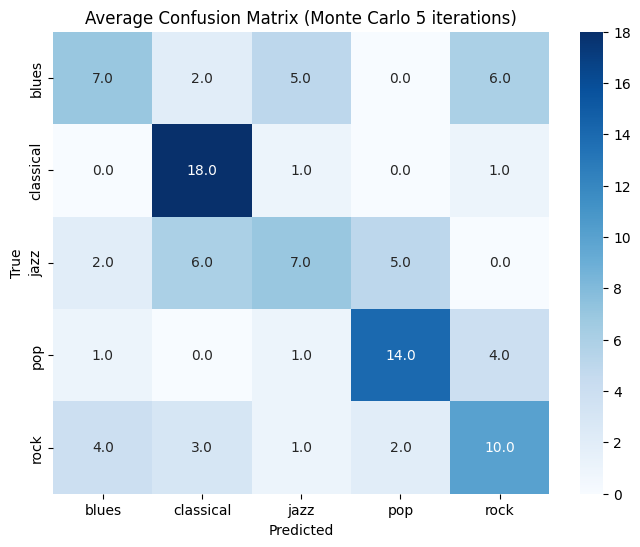

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 假設有五次迭代的結果
all_conf_matrices = []

for iteration in range(5):
    # test_true, test_preds 為該次迭代的真實標籤與預測標籤
    cm = confusion_matrix(test_true, test_preds, labels=genres)
    all_conf_matrices.append(cm)

# 計算平均混淆矩陣
avg_cm = np.mean(all_conf_matrices, axis=0)

plt.figure(figsize=(8,6))
sns.heatmap(avg_cm, annot=True, fmt=".1f", xticklabels=genres, yticklabels=genres, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Average Confusion Matrix (Monte Carlo 5 iterations)")
plt.show()


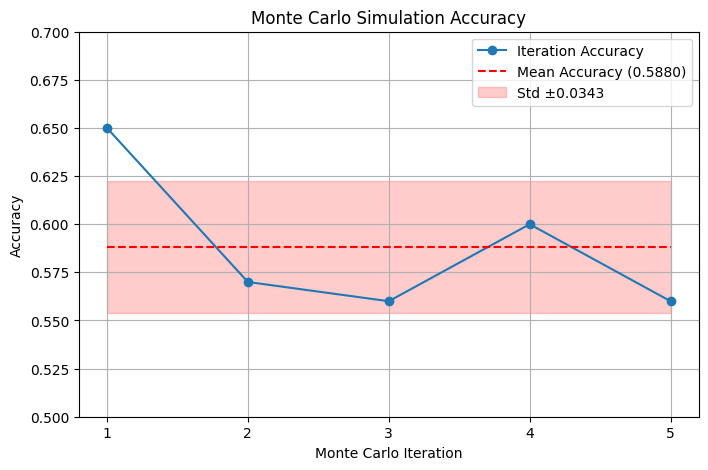

In [5]:
import matplotlib.pyplot as plt

# 假設 acc_scores 已經有五次蒙地卡羅結果
# acc_scores = [0.82, 0.85, 0.80, 0.83, 0.81]

iterations = np.arange(1, len(acc_scores)+1)

mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)

plt.figure(figsize=(8,5))
plt.plot(iterations, acc_scores, marker='o', linestyle='-', label='Iteration Accuracy')
plt.hlines(mean_acc, 1, len(acc_scores), colors='r', linestyles='dashed', label=f'Mean Accuracy ({mean_acc:.4f})')
plt.fill_between(iterations, mean_acc-std_acc, mean_acc+std_acc, color='r', alpha=0.2, label=f'Std ±{std_acc:.4f}')

plt.xticks(iterations)
plt.ylim(0.5, 0.7)
plt.xlabel("Monte Carlo Iteration")
plt.ylabel("Accuracy")
plt.title("Monte Carlo Simulation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### (ZCR + SC + SR + MFCC) * (Mean + Variance)

- 類別 : ['blues', 'classical', 'jazz', 'pop', 'rock']
- 樣本數 : 每類各 100 筆，共 499 筆 (jazz 有 1 筆檔案毀損)
- 特徵長度 : 1s
- 切割重疊時長 : 0.5s
- 蒙地卡羅次數 : 5
- 訓練集:測試集 = 8:2

In [6]:
import os
import platform
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
from multiprocessing import cpu_count

# --- 平行運算選擇 ---
if platform.system() == "Windows":
    from multiprocessing.dummy import Pool  # Windows 多執行緒
else:
    from multiprocessing import Pool        # Linux/macOS 多進程

# --- 參數設定 ---
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']

texture_window = 1.0
overlap = 0.5
n_iterations = 5
test_size = 0.2

# === 特徵提取函數 ===
def extract_features_from_segment(y_segment, sr):
    zcr = librosa.feature.zero_crossing_rate(y=y_segment)[0]
    centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)[0]
    mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
    return np.hstack([
        np.mean(zcr), np.var(zcr),
        np.mean(centroid), np.var(centroid),
        np.mean(rolloff), np.var(rolloff),
        np.mean(mfcc, axis=1), np.var(mfcc, axis=1)
    ])

def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1 - overlap))
    features = []
    for start in range(0, len(y) - texture_samples, hop_samples):
        segment = y[start:start + texture_samples]
        features.append(extract_features_from_segment(segment, sr))
    return np.array(features)

def parallel_feature_extraction(file_label_pairs):
    features, labels = [], []
    for file_path, label in file_label_pairs:
        feats = process_audio_file(file_path)
        for f in feats:
            features.append(f)
            labels.append(label)
    return features, labels

def most_common_label(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

if __name__ == "__main__":
    # --- 預熱 librosa / numba ---
    _ = librosa.hz_to_note(440.0)

    # --- 收集資料集 ---
    all_files, all_labels = [], []
    for genre in genres:
        genre_path = os.path.join(DATASET_PATH, genre)
        files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.wav')]
        all_files.extend(files)
        all_labels.extend([genre] * len(files))

    all_files = np.array(all_files)
    all_labels = np.array(all_labels)
    print(f"Total files: {len(all_files)}")

    acc_scores = []

    # === Monte Carlo 模擬 ===
    for iteration in range(1, n_iterations + 1):
        print(f"\n=== Monte Carlo Iteration {iteration} ===")

        # 分割資料
        train_files, test_files, train_labels, test_labels = train_test_split(
            all_files, all_labels, test_size=test_size, stratify=all_labels, random_state=iteration
        )
        print(f"Training samples: {len(train_files)}, Testing samples: {len(test_files)}")

        # 平行提取訓練特徵
        chunk_size = 5
        train_pairs = list(zip(train_files, train_labels))
        print(f"使用 {cpu_count()} 核心平行提取訓練特徵中...")

        with Pool(processes=cpu_count()) as pool:
            results = list(tqdm(
                pool.imap_unordered(parallel_feature_extraction,
                                    [train_pairs[i:i + chunk_size] for i in range(0, len(train_pairs), chunk_size)]),
                total=max(1, len(train_pairs) // chunk_size)
            ))

        train_features, train_y = [], []
        for f, l in results:
            train_features.extend(f)
            train_y.extend(l)

        X_train = np.array(train_features)
        print(f"訓練特徵矩陣 shape: {X_train.shape}")

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        y_train = np.array(train_y)

        model = LogisticRegression(max_iter=1000, solver='lbfgs')
        model.fit(X_train, y_train)

        # 平行提取測試特徵並以投票方式分類
        test_preds, test_true = [], []
        print(f"Processing test files...")
        pbar = tqdm(test_files, total=len(test_files))
        for fpath in pbar:
            feats = process_audio_file(fpath)
            feats = scaler.transform(feats)
            segment_preds = model.predict(feats)
            song_pred = most_common_label(segment_preds)
            test_preds.append(song_pred)
            # 將檔名和 shape 顯示在進度條右側
            pbar.set_postfix_str(f"{os.path.basename(fpath)} shape: {feats.shape}")
        # 測試標籤
        test_true = list(test_labels)

        acc = accuracy_score(test_true, test_preds)
        acc_scores.append(acc)

        print(f"Iteration {iteration} Accuracy: {acc:.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(test_true, test_preds))
        print("Classification Report:")
        print(classification_report(test_true, test_preds))

    print("\n=== Monte Carlo Summary ===")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Std Accuracy: {np.std(acc_scores):.4f}")


Total files: 499

=== Monte Carlo Iteration 1 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


80it [02:38,  1.98s/it]                        


訓練特徵矩陣 shape: (23538, 32)
Processing test files...


  1%|          | 1/100 [00:00<00:28,  3.53it/s]

jazz.00044.wav 特徵矩陣 shape: (59, 32)


  2%|▏         | 2/100 [00:00<00:27,  3.52it/s]

pop.00026.wav 特徵矩陣 shape: (59, 32)


  3%|▎         | 3/100 [00:00<00:28,  3.42it/s]

jazz.00014.wav 特徵矩陣 shape: (59, 32)


  4%|▍         | 4/100 [00:01<00:27,  3.46it/s]

blues.00001.wav 特徵矩陣 shape: (59, 32)


  5%|▌         | 5/100 [00:01<00:27,  3.49it/s]

pop.00098.wav 特徵矩陣 shape: (59, 32)


  6%|▌         | 6/100 [00:01<00:26,  3.52it/s]

blues.00079.wav 特徵矩陣 shape: (59, 32)


  7%|▋         | 7/100 [00:01<00:26,  3.52it/s]

rock.00028.wav 特徵矩陣 shape: (59, 32)


  8%|▊         | 8/100 [00:02<00:26,  3.51it/s]

classical.00023.wav 特徵矩陣 shape: (59, 32)


  9%|▉         | 9/100 [00:02<00:25,  3.53it/s]

classical.00032.wav 特徵矩陣 shape: (59, 32)


 10%|█         | 10/100 [00:02<00:25,  3.53it/s]

jazz.00065.wav 特徵矩陣 shape: (59, 32)


 11%|█         | 11/100 [00:03<00:25,  3.56it/s]

rock.00070.wav 特徵矩陣 shape: (59, 32)


 12%|█▏        | 12/100 [00:03<00:25,  3.52it/s]

blues.00029.wav 特徵矩陣 shape: (59, 32)


 13%|█▎        | 13/100 [00:03<00:24,  3.55it/s]

rock.00029.wav 特徵矩陣 shape: (59, 32)


 14%|█▍        | 14/100 [00:03<00:24,  3.55it/s]

pop.00064.wav 特徵矩陣 shape: (59, 32)


 15%|█▌        | 15/100 [00:04<00:23,  3.56it/s]

rock.00046.wav 特徵矩陣 shape: (59, 32)


 16%|█▌        | 16/100 [00:04<00:23,  3.56it/s]

pop.00089.wav 特徵矩陣 shape: (59, 32)


 17%|█▋        | 17/100 [00:04<00:23,  3.57it/s]

jazz.00028.wav 特徵矩陣 shape: (59, 32)


 18%|█▊        | 18/100 [00:05<00:22,  3.57it/s]

blues.00016.wav 特徵矩陣 shape: (59, 32)


 19%|█▉        | 19/100 [00:05<00:22,  3.52it/s]

rock.00052.wav 特徵矩陣 shape: (59, 32)


 20%|██        | 20/100 [00:05<00:22,  3.55it/s]

jazz.00041.wav 特徵矩陣 shape: (59, 32)


 21%|██        | 21/100 [00:05<00:22,  3.56it/s]

classical.00007.wav 特徵矩陣 shape: (59, 32)


 22%|██▏       | 22/100 [00:06<00:21,  3.56it/s]

blues.00050.wav 特徵矩陣 shape: (59, 32)


 23%|██▎       | 23/100 [00:06<00:21,  3.56it/s]

pop.00033.wav 特徵矩陣 shape: (59, 32)


 24%|██▍       | 24/100 [00:06<00:21,  3.53it/s]

classical.00076.wav 特徵矩陣 shape: (59, 32)


 25%|██▌       | 25/100 [00:07<00:21,  3.53it/s]

classical.00020.wav 特徵矩陣 shape: (59, 32)


 26%|██▌       | 26/100 [00:07<00:20,  3.55it/s]

classical.00030.wav 特徵矩陣 shape: (59, 32)


 27%|██▋       | 27/100 [00:07<00:20,  3.55it/s]

jazz.00095.wav 特徵矩陣 shape: (59, 32)


 28%|██▊       | 28/100 [00:07<00:20,  3.57it/s]

classical.00096.wav 特徵矩陣 shape: (59, 32)


 29%|██▉       | 29/100 [00:08<00:19,  3.58it/s]

blues.00014.wav 特徵矩陣 shape: (59, 32)


 30%|███       | 30/100 [00:08<00:19,  3.59it/s]

classical.00010.wav 特徵矩陣 shape: (59, 32)


 31%|███       | 31/100 [00:08<00:19,  3.53it/s]

classical.00075.wav 特徵矩陣 shape: (59, 32)


 32%|███▏      | 32/100 [00:09<00:19,  3.58it/s]

pop.00043.wav 特徵矩陣 shape: (59, 32)


 33%|███▎      | 33/100 [00:09<00:18,  3.63it/s]

jazz.00075.wav 特徵矩陣 shape: (59, 32)


 34%|███▍      | 34/100 [00:09<00:18,  3.63it/s]

blues.00075.wav 特徵矩陣 shape: (59, 32)


 35%|███▌      | 35/100 [00:09<00:17,  3.64it/s]

blues.00028.wav 特徵矩陣 shape: (59, 32)


 36%|███▌      | 36/100 [00:10<00:17,  3.65it/s]

classical.00057.wav 特徵矩陣 shape: (59, 32)


 37%|███▋      | 37/100 [00:10<00:17,  3.64it/s]

blues.00018.wav 特徵矩陣 shape: (59, 32)


 38%|███▊      | 38/100 [00:10<00:17,  3.65it/s]

blues.00025.wav 特徵矩陣 shape: (59, 32)


 39%|███▉      | 39/100 [00:10<00:17,  3.54it/s]

jazz.00020.wav 特徵矩陣 shape: (59, 32)


 40%|████      | 40/100 [00:11<00:16,  3.59it/s]

rock.00027.wav 特徵矩陣 shape: (58, 32)


 41%|████      | 41/100 [00:11<00:16,  3.56it/s]

rock.00007.wav 特徵矩陣 shape: (59, 32)


 42%|████▏     | 42/100 [00:11<00:16,  3.56it/s]

rock.00084.wav 特徵矩陣 shape: (59, 32)


 43%|████▎     | 43/100 [00:12<00:15,  3.61it/s]

classical.00074.wav 特徵矩陣 shape: (59, 32)


 44%|████▍     | 44/100 [00:12<00:15,  3.65it/s]

blues.00088.wav 特徵矩陣 shape: (59, 32)


 45%|████▌     | 45/100 [00:12<00:14,  3.67it/s]

pop.00073.wav 特徵矩陣 shape: (59, 32)


 46%|████▌     | 46/100 [00:12<00:14,  3.67it/s]

classical.00068.wav 特徵矩陣 shape: (59, 32)


 47%|████▋     | 47/100 [00:13<00:14,  3.67it/s]

classical.00093.wav 特徵矩陣 shape: (59, 32)


 48%|████▊     | 48/100 [00:13<00:14,  3.68it/s]

jazz.00085.wav 特徵矩陣 shape: (59, 32)


 49%|████▉     | 49/100 [00:13<00:13,  3.68it/s]

pop.00091.wav 特徵矩陣 shape: (59, 32)


 50%|█████     | 50/100 [00:13<00:13,  3.67it/s]

jazz.00008.wav 特徵矩陣 shape: (59, 32)


 51%|█████     | 51/100 [00:14<00:13,  3.64it/s]

classical.00024.wav 特徵矩陣 shape: (59, 32)


 52%|█████▏    | 52/100 [00:14<00:13,  3.62it/s]

jazz.00030.wav 特徵矩陣 shape: (59, 32)


 53%|█████▎    | 53/100 [00:14<00:13,  3.61it/s]

jazz.00050.wav 特徵矩陣 shape: (59, 32)


 54%|█████▍    | 54/100 [00:15<00:12,  3.61it/s]

jazz.00019.wav 特徵矩陣 shape: (59, 32)


 55%|█████▌    | 55/100 [00:15<00:12,  3.63it/s]

pop.00096.wav 特徵矩陣 shape: (59, 32)


 56%|█████▌    | 56/100 [00:15<00:12,  3.63it/s]

classical.00045.wav 特徵矩陣 shape: (59, 32)


 57%|█████▋    | 57/100 [00:15<00:11,  3.60it/s]

pop.00001.wav 特徵矩陣 shape: (59, 32)


 58%|█████▊    | 58/100 [00:16<00:11,  3.62it/s]

blues.00076.wav 特徵矩陣 shape: (59, 32)


 59%|█████▉    | 59/100 [00:16<00:11,  3.67it/s]

pop.00056.wav 特徵矩陣 shape: (59, 32)


 60%|██████    | 60/100 [00:16<00:10,  3.69it/s]

blues.00071.wav 特徵矩陣 shape: (59, 32)


 61%|██████    | 61/100 [00:16<00:10,  3.70it/s]

pop.00052.wav 特徵矩陣 shape: (59, 32)


 62%|██████▏   | 62/100 [00:17<00:10,  3.68it/s]

blues.00011.wav 特徵矩陣 shape: (59, 32)


 63%|██████▎   | 63/100 [00:17<00:10,  3.65it/s]

jazz.00096.wav 特徵矩陣 shape: (59, 32)


 64%|██████▍   | 64/100 [00:17<00:09,  3.63it/s]

classical.00081.wav 特徵矩陣 shape: (59, 32)


 65%|██████▌   | 65/100 [00:18<00:09,  3.63it/s]

classical.00043.wav 特徵矩陣 shape: (59, 32)


 66%|██████▌   | 66/100 [00:18<00:09,  3.63it/s]

classical.00036.wav 特徵矩陣 shape: (59, 32)


 67%|██████▋   | 67/100 [00:18<00:09,  3.53it/s]

rock.00050.wav 特徵矩陣 shape: (59, 32)


 68%|██████▊   | 68/100 [00:18<00:08,  3.56it/s]

pop.00030.wav 特徵矩陣 shape: (59, 32)


 69%|██████▉   | 69/100 [00:19<00:08,  3.55it/s]

jazz.00080.wav 特徵矩陣 shape: (59, 32)


 70%|███████   | 70/100 [00:19<00:08,  3.53it/s]

rock.00061.wav 特徵矩陣 shape: (59, 32)


 71%|███████   | 71/100 [00:19<00:08,  3.56it/s]

rock.00036.wav 特徵矩陣 shape: (59, 32)


 72%|███████▏  | 72/100 [00:20<00:07,  3.58it/s]

jazz.00015.wav 特徵矩陣 shape: (59, 32)


 73%|███████▎  | 73/100 [00:20<00:07,  3.61it/s]

rock.00018.wav 特徵矩陣 shape: (59, 32)


 74%|███████▍  | 74/100 [00:20<00:07,  3.62it/s]

jazz.00032.wav 特徵矩陣 shape: (59, 32)


 75%|███████▌  | 75/100 [00:20<00:06,  3.62it/s]

rock.00008.wav 特徵矩陣 shape: (59, 32)


 76%|███████▌  | 76/100 [00:21<00:06,  3.63it/s]

rock.00014.wav 特徵矩陣 shape: (59, 32)


 77%|███████▋  | 77/100 [00:21<00:06,  3.60it/s]

pop.00084.wav 特徵矩陣 shape: (59, 32)


 78%|███████▊  | 78/100 [00:21<00:06,  3.64it/s]

pop.00022.wav 特徵矩陣 shape: (59, 32)


 79%|███████▉  | 79/100 [00:21<00:05,  3.64it/s]

rock.00040.wav 特徵矩陣 shape: (59, 32)


 80%|████████  | 80/100 [00:22<00:05,  3.67it/s]

blues.00020.wav 特徵矩陣 shape: (59, 32)


 81%|████████  | 81/100 [00:22<00:05,  3.65it/s]

jazz.00024.wav 特徵矩陣 shape: (59, 32)


 82%|████████▏ | 82/100 [00:22<00:04,  3.61it/s]

rock.00048.wav 特徵矩陣 shape: (59, 32)


 83%|████████▎ | 83/100 [00:23<00:04,  3.51it/s]

rock.00011.wav 特徵矩陣 shape: (59, 32)


 84%|████████▍ | 84/100 [00:23<00:04,  3.53it/s]

classical.00082.wav 特徵矩陣 shape: (59, 32)


 85%|████████▌ | 85/100 [00:23<00:04,  3.42it/s]

blues.00006.wav 特徵矩陣 shape: (59, 32)


 86%|████████▌ | 86/100 [00:24<00:04,  3.20it/s]

pop.00069.wav 特徵矩陣 shape: (59, 32)


 87%|████████▋ | 87/100 [00:24<00:04,  3.22it/s]

blues.00084.wav 特徵矩陣 shape: (59, 32)


 88%|████████▊ | 88/100 [00:24<00:03,  3.31it/s]

blues.00005.wav 特徵矩陣 shape: (59, 32)


 89%|████████▉ | 89/100 [00:24<00:03,  3.41it/s]

blues.00009.wav 特徵矩陣 shape: (59, 32)


 90%|█████████ | 90/100 [00:25<00:02,  3.46it/s]

classical.00013.wav 特徵矩陣 shape: (59, 32)


 91%|█████████ | 91/100 [00:25<00:02,  3.42it/s]

rock.00016.wav 特徵矩陣 shape: (59, 32)


 92%|█████████▏| 92/100 [00:25<00:02,  3.42it/s]

pop.00082.wav 特徵矩陣 shape: (59, 32)


 93%|█████████▎| 93/100 [00:26<00:02,  3.45it/s]

pop.00027.wav 特徵矩陣 shape: (59, 32)


 94%|█████████▍| 94/100 [00:26<00:01,  3.51it/s]

jazz.00078.wav 特徵矩陣 shape: (59, 32)


 95%|█████████▌| 95/100 [00:26<00:01,  3.54it/s]

pop.00095.wav 特徵矩陣 shape: (59, 32)


 96%|█████████▌| 96/100 [00:26<00:01,  3.57it/s]

blues.00064.wav 特徵矩陣 shape: (59, 32)


 97%|█████████▋| 97/100 [00:27<00:00,  3.59it/s]

rock.00030.wav 特徵矩陣 shape: (59, 32)


 98%|█████████▊| 98/100 [00:27<00:00,  3.46it/s]

rock.00085.wav 特徵矩陣 shape: (59, 32)


 99%|█████████▉| 99/100 [00:27<00:00,  3.47it/s]

pop.00099.wav 特徵矩陣 shape: (59, 32)


100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


jazz.00084.wav 特徵矩陣 shape: (59, 32)
Iteration 1 Accuracy: 0.8300
Confusion Matrix:
[[15  0  3  0  2]
 [ 0 20  0  0  0]
 [ 1  1 16  0  2]
 [ 0  0  0 19  1]
 [ 4  0  2  1 13]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.75      0.75      0.75        20
   classical       0.95      1.00      0.98        20
        jazz       0.76      0.80      0.78        20
         pop       0.95      0.95      0.95        20
        rock       0.72      0.65      0.68        20

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100


=== Monte Carlo Iteration 2 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


80it [02:52,  2.15s/it]                        


訓練特徵矩陣 shape: (23538, 32)
Processing test files...


  1%|          | 1/100 [00:00<00:26,  3.74it/s]

rock.00012.wav 特徵矩陣 shape: (59, 32)


  2%|▏         | 2/100 [00:00<00:26,  3.68it/s]

classical.00058.wav 特徵矩陣 shape: (59, 32)


  3%|▎         | 3/100 [00:00<00:27,  3.57it/s]

blues.00034.wav 特徵矩陣 shape: (59, 32)


  4%|▍         | 4/100 [00:01<00:26,  3.59it/s]

classical.00039.wav 特徵矩陣 shape: (59, 32)


  5%|▌         | 5/100 [00:01<00:26,  3.61it/s]

rock.00015.wav 特徵矩陣 shape: (59, 32)


  6%|▌         | 6/100 [00:01<00:26,  3.61it/s]

jazz.00081.wav 特徵矩陣 shape: (59, 32)


  7%|▋         | 7/100 [00:01<00:25,  3.61it/s]

pop.00014.wav 特徵矩陣 shape: (59, 32)


  8%|▊         | 8/100 [00:02<00:25,  3.61it/s]

classical.00036.wav 特徵矩陣 shape: (59, 32)


  9%|▉         | 9/100 [00:02<00:24,  3.64it/s]

blues.00082.wav 特徵矩陣 shape: (59, 32)


 10%|█         | 10/100 [00:02<00:24,  3.64it/s]

pop.00011.wav 特徵矩陣 shape: (59, 32)


 11%|█         | 11/100 [00:03<00:24,  3.64it/s]

rock.00097.wav 特徵矩陣 shape: (59, 32)


 12%|█▏        | 12/100 [00:03<00:24,  3.65it/s]

blues.00020.wav 特徵矩陣 shape: (59, 32)


 13%|█▎        | 13/100 [00:03<00:24,  3.60it/s]

pop.00086.wav 特徵矩陣 shape: (59, 32)


 14%|█▍        | 14/100 [00:03<00:23,  3.62it/s]

pop.00082.wav 特徵矩陣 shape: (59, 32)


 15%|█▌        | 15/100 [00:04<00:23,  3.65it/s]

pop.00094.wav 特徵矩陣 shape: (59, 32)


 16%|█▌        | 16/100 [00:04<00:22,  3.66it/s]

blues.00063.wav 特徵矩陣 shape: (59, 32)


 17%|█▋        | 17/100 [00:04<00:22,  3.65it/s]

blues.00004.wav 特徵矩陣 shape: (59, 32)


 18%|█▊        | 18/100 [00:04<00:22,  3.65it/s]

jazz.00058.wav 特徵矩陣 shape: (59, 32)


 19%|█▉        | 19/100 [00:05<00:22,  3.67it/s]

pop.00093.wav 特徵矩陣 shape: (59, 32)


 20%|██        | 20/100 [00:05<00:21,  3.67it/s]

rock.00060.wav 特徵矩陣 shape: (59, 32)


 21%|██        | 21/100 [00:05<00:21,  3.61it/s]

jazz.00014.wav 特徵矩陣 shape: (59, 32)


 22%|██▏       | 22/100 [00:06<00:21,  3.61it/s]

rock.00025.wav 特徵矩陣 shape: (59, 32)


 23%|██▎       | 23/100 [00:06<00:21,  3.61it/s]

jazz.00020.wav 特徵矩陣 shape: (59, 32)


 24%|██▍       | 24/100 [00:06<00:20,  3.64it/s]

blues.00039.wav 特徵矩陣 shape: (59, 32)


 25%|██▌       | 25/100 [00:06<00:20,  3.64it/s]

classical.00059.wav 特徵矩陣 shape: (59, 32)


 26%|██▌       | 26/100 [00:07<00:20,  3.65it/s]

pop.00003.wav 特徵矩陣 shape: (59, 32)


 27%|██▋       | 27/100 [00:07<00:20,  3.65it/s]

classical.00040.wav 特徵矩陣 shape: (59, 32)


 28%|██▊       | 28/100 [00:07<00:19,  3.64it/s]

jazz.00083.wav 特徵矩陣 shape: (59, 32)


 29%|██▉       | 29/100 [00:07<00:19,  3.67it/s]

classical.00020.wav 特徵矩陣 shape: (59, 32)


 30%|███       | 30/100 [00:08<00:19,  3.66it/s]

jazz.00088.wav 特徵矩陣 shape: (59, 32)


 31%|███       | 31/100 [00:08<00:18,  3.64it/s]

jazz.00094.wav 特徵矩陣 shape: (59, 32)


 32%|███▏      | 32/100 [00:08<00:19,  3.53it/s]

jazz.00086.wav 特徵矩陣 shape: (59, 32)


 33%|███▎      | 33/100 [00:09<00:18,  3.55it/s]

jazz.00072.wav 特徵矩陣 shape: (59, 32)


 34%|███▍      | 34/100 [00:09<00:18,  3.55it/s]

rock.00023.wav 特徵矩陣 shape: (59, 32)


 35%|███▌      | 35/100 [00:09<00:18,  3.56it/s]

pop.00043.wav 特徵矩陣 shape: (59, 32)


 36%|███▌      | 36/100 [00:09<00:17,  3.56it/s]

rock.00083.wav 特徵矩陣 shape: (59, 32)


 37%|███▋      | 37/100 [00:10<00:17,  3.57it/s]

blues.00031.wav 特徵矩陣 shape: (59, 32)


 38%|███▊      | 38/100 [00:10<00:17,  3.54it/s]

rock.00032.wav 特徵矩陣 shape: (59, 32)


 39%|███▉      | 39/100 [00:10<00:17,  3.56it/s]

classical.00049.wav 特徵矩陣 shape: (58, 32)


 40%|████      | 40/100 [00:11<00:16,  3.58it/s]

classical.00000.wav 特徵矩陣 shape: (59, 32)


 41%|████      | 41/100 [00:11<00:16,  3.55it/s]

classical.00093.wav 特徵矩陣 shape: (59, 32)


 42%|████▏     | 42/100 [00:11<00:16,  3.55it/s]

rock.00005.wav 特徵矩陣 shape: (59, 32)


 43%|████▎     | 43/100 [00:11<00:16,  3.41it/s]

rock.00004.wav 特徵矩陣 shape: (59, 32)


 44%|████▍     | 44/100 [00:12<00:16,  3.47it/s]

blues.00043.wav 特徵矩陣 shape: (59, 32)


 45%|████▌     | 45/100 [00:12<00:15,  3.47it/s]

blues.00042.wav 特徵矩陣 shape: (59, 32)


 46%|████▌     | 46/100 [00:12<00:15,  3.50it/s]

rock.00041.wav 特徵矩陣 shape: (59, 32)


 47%|████▋     | 47/100 [00:13<00:14,  3.53it/s]

jazz.00024.wav 特徵矩陣 shape: (59, 32)


 48%|████▊     | 48/100 [00:13<00:14,  3.55it/s]

pop.00065.wav 特徵矩陣 shape: (59, 32)


 49%|████▉     | 49/100 [00:13<00:14,  3.56it/s]

classical.00062.wav 特徵矩陣 shape: (59, 32)


 50%|█████     | 50/100 [00:13<00:14,  3.46it/s]

jazz.00043.wav 特徵矩陣 shape: (59, 32)


 51%|█████     | 51/100 [00:14<00:14,  3.44it/s]

classical.00027.wav 特徵矩陣 shape: (59, 32)


 52%|█████▏    | 52/100 [00:14<00:14,  3.41it/s]

jazz.00070.wav 特徵矩陣 shape: (59, 32)


 53%|█████▎    | 53/100 [00:14<00:13,  3.40it/s]

jazz.00065.wav 特徵矩陣 shape: (59, 32)


 54%|█████▍    | 54/100 [00:15<00:13,  3.45it/s]

classical.00063.wav 特徵矩陣 shape: (59, 32)


 55%|█████▌    | 55/100 [00:15<00:12,  3.47it/s]

rock.00066.wav 特徵矩陣 shape: (59, 32)


 56%|█████▌    | 56/100 [00:15<00:12,  3.51it/s]

classical.00022.wav 特徵矩陣 shape: (59, 32)


 57%|█████▋    | 57/100 [00:15<00:12,  3.53it/s]

rock.00081.wav 特徵矩陣 shape: (59, 32)


 58%|█████▊    | 58/100 [00:16<00:11,  3.57it/s]

jazz.00038.wav 特徵矩陣 shape: (59, 32)


 59%|█████▉    | 59/100 [00:16<00:11,  3.57it/s]

rock.00045.wav 特徵矩陣 shape: (59, 32)


 60%|██████    | 60/100 [00:16<00:11,  3.51it/s]

jazz.00021.wav 特徵矩陣 shape: (59, 32)


 61%|██████    | 61/100 [00:17<00:11,  3.54it/s]

rock.00036.wav 特徵矩陣 shape: (59, 32)


 62%|██████▏   | 62/100 [00:17<00:10,  3.57it/s]

rock.00011.wav 特徵矩陣 shape: (59, 32)


 63%|██████▎   | 63/100 [00:17<00:10,  3.58it/s]

pop.00019.wav 特徵矩陣 shape: (59, 32)


 64%|██████▍   | 64/100 [00:17<00:10,  3.60it/s]

classical.00073.wav 特徵矩陣 shape: (59, 32)


 65%|██████▌   | 65/100 [00:18<00:09,  3.60it/s]

blues.00051.wav 特徵矩陣 shape: (59, 32)


 66%|██████▌   | 66/100 [00:18<00:09,  3.60it/s]

jazz.00028.wav 特徵矩陣 shape: (59, 32)


 67%|██████▋   | 67/100 [00:18<00:09,  3.61it/s]

classical.00050.wav 特徵矩陣 shape: (59, 32)


 68%|██████▊   | 68/100 [00:19<00:08,  3.61it/s]

rock.00086.wav 特徵矩陣 shape: (59, 32)


 69%|██████▉   | 69/100 [00:19<00:08,  3.51it/s]

blues.00022.wav 特徵矩陣 shape: (59, 32)


 70%|███████   | 70/100 [00:19<00:08,  3.53it/s]

pop.00035.wav 特徵矩陣 shape: (59, 32)


 71%|███████   | 71/100 [00:19<00:08,  3.55it/s]

pop.00081.wav 特徵矩陣 shape: (59, 32)


 72%|███████▏  | 72/100 [00:20<00:07,  3.58it/s]

blues.00085.wav 特徵矩陣 shape: (59, 32)


 73%|███████▎  | 73/100 [00:20<00:07,  3.59it/s]

blues.00038.wav 特徵矩陣 shape: (59, 32)


 74%|███████▍  | 74/100 [00:20<00:07,  3.58it/s]

blues.00037.wav 特徵矩陣 shape: (59, 32)


 75%|███████▌  | 75/100 [00:20<00:06,  3.58it/s]

rock.00076.wav 特徵矩陣 shape: (59, 32)


 76%|███████▌  | 76/100 [00:21<00:06,  3.58it/s]

pop.00099.wav 特徵矩陣 shape: (59, 32)


 77%|███████▋  | 77/100 [00:21<00:06,  3.59it/s]

jazz.00022.wav 特徵矩陣 shape: (59, 32)


 78%|███████▊  | 78/100 [00:21<00:06,  3.53it/s]

classical.00026.wav 特徵矩陣 shape: (59, 32)


 79%|███████▉  | 79/100 [00:22<00:05,  3.55it/s]

classical.00075.wav 特徵矩陣 shape: (59, 32)


 80%|████████  | 80/100 [00:22<00:05,  3.58it/s]

pop.00005.wav 特徵矩陣 shape: (59, 32)


 81%|████████  | 81/100 [00:22<00:05,  3.57it/s]

blues.00096.wav 特徵矩陣 shape: (59, 32)


 82%|████████▏ | 82/100 [00:22<00:05,  3.57it/s]

jazz.00080.wav 特徵矩陣 shape: (59, 32)


 83%|████████▎ | 83/100 [00:23<00:04,  3.58it/s]

blues.00067.wav 特徵矩陣 shape: (59, 32)


 84%|████████▍ | 84/100 [00:23<00:04,  3.60it/s]

pop.00064.wav 特徵矩陣 shape: (59, 32)


 85%|████████▌ | 85/100 [00:23<00:04,  3.60it/s]

jazz.00006.wav 特徵矩陣 shape: (59, 32)


 86%|████████▌ | 86/100 [00:24<00:03,  3.58it/s]

classical.00097.wav 特徵矩陣 shape: (59, 32)


 87%|████████▋ | 87/100 [00:24<00:03,  3.54it/s]

classical.00001.wav 特徵矩陣 shape: (59, 32)


 88%|████████▊ | 88/100 [00:24<00:03,  3.56it/s]

blues.00049.wav 特徵矩陣 shape: (59, 32)


 89%|████████▉ | 89/100 [00:24<00:03,  3.57it/s]

rock.00072.wav 特徵矩陣 shape: (59, 32)


 90%|█████████ | 90/100 [00:25<00:02,  3.57it/s]

pop.00029.wav 特徵矩陣 shape: (59, 32)


 91%|█████████ | 91/100 [00:25<00:02,  3.56it/s]

classical.00007.wav 特徵矩陣 shape: (59, 32)


 92%|█████████▏| 92/100 [00:25<00:02,  3.53it/s]

pop.00010.wav 特徵矩陣 shape: (59, 32)


 93%|█████████▎| 93/100 [00:26<00:01,  3.56it/s]

pop.00042.wav 特徵矩陣 shape: (59, 32)


 94%|█████████▍| 94/100 [00:26<00:01,  3.54it/s]

pop.00034.wav 特徵矩陣 shape: (59, 32)


 95%|█████████▌| 95/100 [00:26<00:01,  3.56it/s]

pop.00041.wav 特徵矩陣 shape: (59, 32)


 96%|█████████▌| 96/100 [00:26<00:01,  3.51it/s]

blues.00075.wav 特徵矩陣 shape: (59, 32)


 97%|█████████▋| 97/100 [00:27<00:00,  3.54it/s]

blues.00047.wav 特徵矩陣 shape: (59, 32)


 98%|█████████▊| 98/100 [00:27<00:00,  3.56it/s]

rock.00088.wav 特徵矩陣 shape: (59, 32)


 99%|█████████▉| 99/100 [00:27<00:00,  3.58it/s]

blues.00007.wav 特徵矩陣 shape: (59, 32)


100%|██████████| 100/100 [00:28<00:00,  3.57it/s]


jazz.00033.wav 特徵矩陣 shape: (59, 32)
Iteration 2 Accuracy: 0.8100
Confusion Matrix:
[[18  0  1  0  1]
 [ 0 19  1  0  0]
 [ 2  1 16  0  1]
 [ 0  0  1 14  5]
 [ 5  0  1  0 14]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.72      0.90      0.80        20
   classical       0.95      0.95      0.95        20
        jazz       0.80      0.80      0.80        20
         pop       1.00      0.70      0.82        20
        rock       0.67      0.70      0.68        20

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100


=== Monte Carlo Iteration 3 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


80it [03:07,  2.34s/it]                        


訓練特徵矩陣 shape: (23538, 32)
Processing test files...


  1%|          | 1/100 [00:00<00:27,  3.58it/s]

jazz.00034.wav 特徵矩陣 shape: (59, 32)


  2%|▏         | 2/100 [00:00<00:27,  3.60it/s]

classical.00018.wav 特徵矩陣 shape: (59, 32)


  3%|▎         | 3/100 [00:00<00:27,  3.59it/s]

rock.00085.wav 特徵矩陣 shape: (59, 32)


  4%|▍         | 4/100 [00:01<00:27,  3.55it/s]

classical.00022.wav 特徵矩陣 shape: (59, 32)


  5%|▌         | 5/100 [00:01<00:26,  3.55it/s]

jazz.00039.wav 特徵矩陣 shape: (59, 32)


  6%|▌         | 6/100 [00:01<00:27,  3.47it/s]

pop.00005.wav 特徵矩陣 shape: (59, 32)


  7%|▋         | 7/100 [00:01<00:26,  3.52it/s]

classical.00035.wav 特徵矩陣 shape: (59, 32)


  8%|▊         | 8/100 [00:02<00:25,  3.55it/s]

classical.00039.wav 特徵矩陣 shape: (59, 32)


  9%|▉         | 9/100 [00:02<00:25,  3.57it/s]

jazz.00045.wav 特徵矩陣 shape: (59, 32)


 10%|█         | 10/100 [00:02<00:25,  3.55it/s]

classical.00020.wav 特徵矩陣 shape: (59, 32)


 11%|█         | 11/100 [00:03<00:25,  3.56it/s]

classical.00098.wav 特徵矩陣 shape: (59, 32)


 12%|█▏        | 12/100 [00:03<00:24,  3.55it/s]

blues.00021.wav 特徵矩陣 shape: (59, 32)


 13%|█▎        | 13/100 [00:03<00:24,  3.57it/s]

blues.00066.wav 特徵矩陣 shape: (59, 32)


 14%|█▍        | 14/100 [00:03<00:24,  3.50it/s]

jazz.00057.wav 特徵矩陣 shape: (59, 32)


 15%|█▌        | 15/100 [00:04<00:24,  3.51it/s]

pop.00038.wav 特徵矩陣 shape: (59, 32)


 16%|█▌        | 16/100 [00:04<00:23,  3.50it/s]

jazz.00004.wav 特徵矩陣 shape: (59, 32)


 17%|█▋        | 17/100 [00:04<00:23,  3.53it/s]

blues.00095.wav 特徵矩陣 shape: (59, 32)


 18%|█▊        | 18/100 [00:05<00:23,  3.56it/s]

blues.00081.wav 特徵矩陣 shape: (59, 32)


 19%|█▉        | 19/100 [00:05<00:23,  3.47it/s]

jazz.00076.wav 特徵矩陣 shape: (59, 32)


 20%|██        | 20/100 [00:05<00:22,  3.48it/s]

jazz.00060.wav 特徵矩陣 shape: (59, 32)


 21%|██        | 21/100 [00:05<00:22,  3.49it/s]

rock.00025.wav 特徵矩陣 shape: (59, 32)


 22%|██▏       | 22/100 [00:06<00:22,  3.47it/s]

rock.00008.wav 特徵矩陣 shape: (59, 32)


 23%|██▎       | 23/100 [00:06<00:22,  3.45it/s]

blues.00000.wav 特徵矩陣 shape: (59, 32)


 24%|██▍       | 24/100 [00:06<00:21,  3.49it/s]

blues.00020.wav 特徵矩陣 shape: (59, 32)


 25%|██▌       | 25/100 [00:07<00:22,  3.27it/s]

blues.00039.wav 特徵矩陣 shape: (59, 32)


 26%|██▌       | 26/100 [00:07<00:22,  3.32it/s]

classical.00063.wav 特徵矩陣 shape: (59, 32)


 27%|██▋       | 27/100 [00:07<00:21,  3.34it/s]

classical.00062.wav 特徵矩陣 shape: (59, 32)


 28%|██▊       | 28/100 [00:08<00:21,  3.28it/s]

classical.00019.wav 特徵矩陣 shape: (59, 32)


 29%|██▉       | 29/100 [00:08<00:21,  3.33it/s]

blues.00026.wav 特徵矩陣 shape: (59, 32)


 30%|███       | 30/100 [00:08<00:20,  3.40it/s]

rock.00010.wav 特徵矩陣 shape: (59, 32)


 31%|███       | 31/100 [00:08<00:20,  3.41it/s]

classical.00045.wav 特徵矩陣 shape: (59, 32)


 32%|███▏      | 32/100 [00:09<00:19,  3.40it/s]

jazz.00072.wav 特徵矩陣 shape: (59, 32)


 33%|███▎      | 33/100 [00:09<00:19,  3.45it/s]

classical.00007.wav 特徵矩陣 shape: (59, 32)


 34%|███▍      | 34/100 [00:09<00:18,  3.48it/s]

pop.00047.wav 特徵矩陣 shape: (59, 32)


 35%|███▌      | 35/100 [00:10<00:18,  3.48it/s]

rock.00061.wav 特徵矩陣 shape: (59, 32)


 36%|███▌      | 36/100 [00:10<00:18,  3.49it/s]

jazz.00007.wav 特徵矩陣 shape: (59, 32)


 37%|███▋      | 37/100 [00:10<00:18,  3.47it/s]

blues.00014.wav 特徵矩陣 shape: (59, 32)


 38%|███▊      | 38/100 [00:10<00:17,  3.48it/s]

blues.00022.wav 特徵矩陣 shape: (59, 32)


 39%|███▉      | 39/100 [00:11<00:17,  3.50it/s]

pop.00011.wav 特徵矩陣 shape: (59, 32)


 40%|████      | 40/100 [00:11<00:17,  3.51it/s]

pop.00075.wav 特徵矩陣 shape: (59, 32)


 41%|████      | 41/100 [00:11<00:17,  3.45it/s]

blues.00010.wav 特徵矩陣 shape: (59, 32)


 42%|████▏     | 42/100 [00:12<00:16,  3.48it/s]

classical.00016.wav 特徵矩陣 shape: (59, 32)


 43%|████▎     | 43/100 [00:12<00:16,  3.48it/s]

pop.00050.wav 特徵矩陣 shape: (59, 32)


 44%|████▍     | 44/100 [00:12<00:15,  3.50it/s]

rock.00083.wav 特徵矩陣 shape: (59, 32)


 45%|████▌     | 45/100 [00:12<00:15,  3.52it/s]

jazz.00042.wav 特徵矩陣 shape: (59, 32)


 46%|████▌     | 46/100 [00:13<00:15,  3.44it/s]

rock.00005.wav 特徵矩陣 shape: (59, 32)


 47%|████▋     | 47/100 [00:13<00:15,  3.46it/s]

rock.00049.wav 特徵矩陣 shape: (59, 32)


 48%|████▊     | 48/100 [00:13<00:14,  3.48it/s]

rock.00059.wav 特徵矩陣 shape: (59, 32)


 49%|████▉     | 49/100 [00:14<00:14,  3.50it/s]

pop.00030.wav 特徵矩陣 shape: (59, 32)


 50%|█████     | 50/100 [00:14<00:14,  3.52it/s]

classical.00002.wav 特徵矩陣 shape: (59, 32)


 51%|█████     | 51/100 [00:14<00:14,  3.49it/s]

jazz.00000.wav 特徵矩陣 shape: (59, 32)


 52%|█████▏    | 52/100 [00:14<00:13,  3.51it/s]

rock.00054.wav 特徵矩陣 shape: (59, 32)


 53%|█████▎    | 53/100 [00:15<00:13,  3.54it/s]

rock.00046.wav 特徵矩陣 shape: (59, 32)


 54%|█████▍    | 54/100 [00:15<00:12,  3.55it/s]

classical.00044.wav 特徵矩陣 shape: (59, 32)


 55%|█████▌    | 55/100 [00:15<00:12,  3.55it/s]

classical.00081.wav 特徵矩陣 shape: (59, 32)


 56%|█████▌    | 56/100 [00:16<00:12,  3.56it/s]

jazz.00077.wav 特徵矩陣 shape: (59, 32)


 57%|█████▋    | 57/100 [00:16<00:12,  3.56it/s]

pop.00046.wav 特徵矩陣 shape: (59, 32)


 58%|█████▊    | 58/100 [00:16<00:11,  3.56it/s]

pop.00034.wav 特徵矩陣 shape: (59, 32)


 59%|█████▉    | 59/100 [00:16<00:11,  3.57it/s]

blues.00056.wav 特徵矩陣 shape: (59, 32)


 60%|██████    | 60/100 [00:17<00:11,  3.59it/s]

classical.00001.wav 特徵矩陣 shape: (59, 32)


 61%|██████    | 61/100 [00:17<00:10,  3.59it/s]

pop.00080.wav 特徵矩陣 shape: (59, 32)


 62%|██████▏   | 62/100 [00:17<00:10,  3.54it/s]

classical.00052.wav 特徵矩陣 shape: (59, 32)


 63%|██████▎   | 63/100 [00:18<00:10,  3.48it/s]

pop.00070.wav 特徵矩陣 shape: (59, 32)


 64%|██████▍   | 64/100 [00:18<00:10,  3.51it/s]

classical.00065.wav 特徵矩陣 shape: (59, 32)


 65%|██████▌   | 65/100 [00:18<00:10,  3.50it/s]

rock.00084.wav 特徵矩陣 shape: (59, 32)


 66%|██████▌   | 66/100 [00:18<00:09,  3.48it/s]

rock.00009.wav 特徵矩陣 shape: (59, 32)


 67%|██████▋   | 67/100 [00:19<00:09,  3.51it/s]

pop.00022.wav 特徵矩陣 shape: (59, 32)


 68%|██████▊   | 68/100 [00:19<00:09,  3.53it/s]

rock.00038.wav 特徵矩陣 shape: (58, 32)


 69%|██████▉   | 69/100 [00:19<00:08,  3.51it/s]

blues.00003.wav 特徵矩陣 shape: (59, 32)


 70%|███████   | 70/100 [00:20<00:08,  3.52it/s]

pop.00095.wav 特徵矩陣 shape: (59, 32)


 71%|███████   | 71/100 [00:20<00:08,  3.53it/s]

jazz.00086.wav 特徵矩陣 shape: (59, 32)


 72%|███████▏  | 72/100 [00:20<00:07,  3.53it/s]

blues.00072.wav 特徵矩陣 shape: (59, 32)


 73%|███████▎  | 73/100 [00:20<00:07,  3.52it/s]

pop.00065.wav 特徵矩陣 shape: (59, 32)


 74%|███████▍  | 74/100 [00:21<00:07,  3.50it/s]

pop.00060.wav 特徵矩陣 shape: (59, 32)


 75%|███████▌  | 75/100 [00:21<00:07,  3.35it/s]

jazz.00049.wav 特徵矩陣 shape: (59, 32)


 76%|███████▌  | 76/100 [00:21<00:07,  3.41it/s]

blues.00044.wav 特徵矩陣 shape: (59, 32)


 77%|███████▋  | 77/100 [00:22<00:06,  3.43it/s]

jazz.00094.wav 特徵矩陣 shape: (59, 32)


 78%|███████▊  | 78/100 [00:22<00:06,  3.45it/s]

blues.00041.wav 特徵矩陣 shape: (59, 32)


 79%|███████▉  | 79/100 [00:22<00:06,  3.46it/s]

classical.00068.wav 特徵矩陣 shape: (59, 32)


 80%|████████  | 80/100 [00:22<00:05,  3.50it/s]

rock.00075.wav 特徵矩陣 shape: (59, 32)


 81%|████████  | 81/100 [00:23<00:05,  3.51it/s]

jazz.00021.wav 特徵矩陣 shape: (59, 32)


 82%|████████▏ | 82/100 [00:23<00:05,  3.43it/s]

rock.00033.wav 特徵矩陣 shape: (59, 32)


 83%|████████▎ | 83/100 [00:23<00:04,  3.48it/s]

pop.00014.wav 特徵矩陣 shape: (59, 32)


 84%|████████▍ | 84/100 [00:24<00:04,  3.50it/s]

pop.00079.wav 特徵矩陣 shape: (59, 32)


 85%|████████▌ | 85/100 [00:24<00:04,  3.51it/s]

jazz.00030.wav 特徵矩陣 shape: (59, 32)


 86%|████████▌ | 86/100 [00:24<00:04,  3.49it/s]

blues.00038.wav 特徵矩陣 shape: (59, 32)


 87%|████████▋ | 87/100 [00:24<00:03,  3.44it/s]

rock.00092.wav 特徵矩陣 shape: (59, 32)


 88%|████████▊ | 88/100 [00:25<00:03,  3.47it/s]

blues.00019.wav 特徵矩陣 shape: (59, 32)


 89%|████████▉ | 89/100 [00:25<00:03,  3.45it/s]

blues.00002.wav 特徵矩陣 shape: (59, 32)


 90%|█████████ | 90/100 [00:25<00:02,  3.47it/s]

pop.00086.wav 特徵矩陣 shape: (59, 32)


 91%|█████████ | 91/100 [00:26<00:02,  3.47it/s]

pop.00003.wav 特徵矩陣 shape: (59, 32)


 92%|█████████▏| 92/100 [00:26<00:02,  3.42it/s]

jazz.00029.wav 特徵矩陣 shape: (59, 32)


 93%|█████████▎| 93/100 [00:26<00:02,  3.44it/s]

pop.00076.wav 特徵矩陣 shape: (59, 32)


 94%|█████████▍| 94/100 [00:26<00:01,  3.47it/s]

rock.00021.wav 特徵矩陣 shape: (59, 32)


 95%|█████████▌| 95/100 [00:27<00:01,  3.50it/s]

jazz.00058.wav 特徵矩陣 shape: (59, 32)


 96%|█████████▌| 96/100 [00:27<00:01,  3.53it/s]

blues.00074.wav 特徵矩陣 shape: (59, 32)


 97%|█████████▋| 97/100 [00:27<00:00,  3.54it/s]

rock.00068.wav 特徵矩陣 shape: (59, 32)


 98%|█████████▊| 98/100 [00:28<00:00,  3.53it/s]

jazz.00090.wav 特徵矩陣 shape: (59, 32)


 99%|█████████▉| 99/100 [00:28<00:00,  3.53it/s]

rock.00090.wav 特徵矩陣 shape: (59, 32)


100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


classical.00050.wav 特徵矩陣 shape: (59, 32)
Iteration 3 Accuracy: 0.8300
Confusion Matrix:
[[19  0  0  0  1]
 [ 0 20  0  0  0]
 [ 2  3 15  0  0]
 [ 0  0  2 16  2]
 [ 3  0  3  1 13]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.79      0.95      0.86        20
   classical       0.87      1.00      0.93        20
        jazz       0.75      0.75      0.75        20
         pop       0.94      0.80      0.86        20
        rock       0.81      0.65      0.72        20

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100


=== Monte Carlo Iteration 4 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


80it [03:14,  2.43s/it]                         


訓練特徵矩陣 shape: (23538, 32)
Processing test files...


  1%|          | 1/100 [00:00<00:27,  3.58it/s]

rock.00037.wav 特徵矩陣 shape: (59, 32)


  2%|▏         | 2/100 [00:00<00:27,  3.58it/s]

classical.00079.wav 特徵矩陣 shape: (59, 32)


  3%|▎         | 3/100 [00:00<00:27,  3.54it/s]

pop.00045.wav 特徵矩陣 shape: (59, 32)


  4%|▍         | 4/100 [00:01<00:27,  3.55it/s]

classical.00000.wav 特徵矩陣 shape: (59, 32)


  5%|▌         | 5/100 [00:01<00:26,  3.56it/s]

blues.00050.wav 特徵矩陣 shape: (59, 32)


  6%|▌         | 6/100 [00:01<00:26,  3.54it/s]

jazz.00089.wav 特徵矩陣 shape: (59, 32)


  7%|▋         | 7/100 [00:01<00:26,  3.55it/s]

classical.00017.wav 特徵矩陣 shape: (59, 32)


  8%|▊         | 8/100 [00:02<00:25,  3.55it/s]

rock.00099.wav 特徵矩陣 shape: (59, 32)


  9%|▉         | 9/100 [00:02<00:25,  3.52it/s]

rock.00028.wav 特徵矩陣 shape: (59, 32)


 10%|█         | 10/100 [00:02<00:25,  3.49it/s]

pop.00028.wav 特徵矩陣 shape: (59, 32)


 11%|█         | 11/100 [00:03<00:25,  3.49it/s]

jazz.00063.wav 特徵矩陣 shape: (59, 32)


 12%|█▏        | 12/100 [00:03<00:25,  3.52it/s]

jazz.00078.wav 特徵矩陣 shape: (59, 32)


 13%|█▎        | 13/100 [00:03<00:24,  3.52it/s]

jazz.00067.wav 特徵矩陣 shape: (59, 32)


 14%|█▍        | 14/100 [00:03<00:24,  3.52it/s]

classical.00027.wav 特徵矩陣 shape: (59, 32)


 15%|█▌        | 15/100 [00:04<00:24,  3.48it/s]

classical.00086.wav 特徵矩陣 shape: (59, 32)


 16%|█▌        | 16/100 [00:04<00:23,  3.52it/s]

blues.00055.wav 特徵矩陣 shape: (59, 32)


 17%|█▋        | 17/100 [00:04<00:23,  3.54it/s]

rock.00096.wav 特徵矩陣 shape: (59, 32)


 18%|█▊        | 18/100 [00:05<00:23,  3.56it/s]

classical.00060.wav 特徵矩陣 shape: (59, 32)


 19%|█▉        | 19/100 [00:05<00:22,  3.53it/s]

pop.00019.wav 特徵矩陣 shape: (59, 32)


 20%|██        | 20/100 [00:05<00:22,  3.54it/s]

blues.00057.wav 特徵矩陣 shape: (59, 32)


 21%|██        | 21/100 [00:05<00:22,  3.56it/s]

blues.00081.wav 特徵矩陣 shape: (59, 32)


 22%|██▏       | 22/100 [00:06<00:22,  3.51it/s]

classical.00042.wav 特徵矩陣 shape: (59, 32)


 23%|██▎       | 23/100 [00:06<00:22,  3.45it/s]

pop.00060.wav 特徵矩陣 shape: (59, 32)


 24%|██▍       | 24/100 [00:06<00:21,  3.48it/s]

pop.00000.wav 特徵矩陣 shape: (59, 32)


 25%|██▌       | 25/100 [00:07<00:21,  3.54it/s]

blues.00003.wav 特徵矩陣 shape: (59, 32)


 26%|██▌       | 26/100 [00:07<00:20,  3.54it/s]

blues.00058.wav 特徵矩陣 shape: (59, 32)


 27%|██▋       | 27/100 [00:07<00:20,  3.57it/s]

classical.00097.wav 特徵矩陣 shape: (59, 32)


 28%|██▊       | 28/100 [00:07<00:20,  3.60it/s]

blues.00000.wav 特徵矩陣 shape: (59, 32)


 29%|██▉       | 29/100 [00:08<00:20,  3.50it/s]

rock.00013.wav 特徵矩陣 shape: (59, 32)


 30%|███       | 30/100 [00:08<00:19,  3.54it/s]

jazz.00023.wav 特徵矩陣 shape: (59, 32)


 31%|███       | 31/100 [00:08<00:19,  3.57it/s]

pop.00063.wav 特徵矩陣 shape: (59, 32)


 32%|███▏      | 32/100 [00:09<00:19,  3.57it/s]

rock.00056.wav 特徵矩陣 shape: (59, 32)


 33%|███▎      | 33/100 [00:09<00:18,  3.56it/s]

blues.00095.wav 特徵矩陣 shape: (59, 32)


 34%|███▍      | 34/100 [00:09<00:18,  3.57it/s]

classical.00010.wav 特徵矩陣 shape: (59, 32)


 35%|███▌      | 35/100 [00:09<00:18,  3.59it/s]

blues.00052.wav 特徵矩陣 shape: (59, 32)


 36%|███▌      | 36/100 [00:10<00:18,  3.53it/s]

blues.00038.wav 特徵矩陣 shape: (59, 32)


 37%|███▋      | 37/100 [00:10<00:17,  3.53it/s]

jazz.00055.wav 特徵矩陣 shape: (59, 32)


 38%|███▊      | 38/100 [00:10<00:17,  3.56it/s]

blues.00009.wav 特徵矩陣 shape: (59, 32)


 39%|███▉      | 39/100 [00:11<00:17,  3.56it/s]

rock.00092.wav 特徵矩陣 shape: (59, 32)


 40%|████      | 40/100 [00:11<00:16,  3.58it/s]

pop.00065.wav 特徵矩陣 shape: (59, 32)


 41%|████      | 41/100 [00:11<00:16,  3.60it/s]

rock.00094.wav 特徵矩陣 shape: (59, 32)


 42%|████▏     | 42/100 [00:11<00:16,  3.58it/s]

jazz.00079.wav 特徵矩陣 shape: (59, 32)


 43%|████▎     | 43/100 [00:12<00:15,  3.57it/s]

pop.00021.wav 特徵矩陣 shape: (59, 32)


 44%|████▍     | 44/100 [00:12<00:15,  3.55it/s]

rock.00022.wav 特徵矩陣 shape: (59, 32)


 45%|████▌     | 45/100 [00:12<00:15,  3.57it/s]

blues.00021.wav 特徵矩陣 shape: (59, 32)


 46%|████▌     | 46/100 [00:12<00:15,  3.57it/s]

classical.00043.wav 特徵矩陣 shape: (59, 32)


 47%|████▋     | 47/100 [00:13<00:14,  3.56it/s]

pop.00016.wav 特徵矩陣 shape: (59, 32)


 48%|████▊     | 48/100 [00:13<00:15,  3.36it/s]

classical.00085.wav 特徵矩陣 shape: (59, 32)


 49%|████▉     | 49/100 [00:13<00:15,  3.40it/s]

jazz.00094.wav 特徵矩陣 shape: (59, 32)


 50%|█████     | 50/100 [00:14<00:14,  3.46it/s]

jazz.00040.wav 特徵矩陣 shape: (59, 32)


 51%|█████     | 51/100 [00:14<00:14,  3.48it/s]

rock.00073.wav 特徵矩陣 shape: (59, 32)


 52%|█████▏    | 52/100 [00:14<00:13,  3.48it/s]

classical.00013.wav 特徵矩陣 shape: (59, 32)


 53%|█████▎    | 53/100 [00:15<00:13,  3.50it/s]

pop.00089.wav 特徵矩陣 shape: (59, 32)


 54%|█████▍    | 54/100 [00:15<00:13,  3.51it/s]

classical.00059.wav 特徵矩陣 shape: (59, 32)


 55%|█████▌    | 55/100 [00:15<00:12,  3.47it/s]

pop.00010.wav 特徵矩陣 shape: (59, 32)


 56%|█████▌    | 56/100 [00:15<00:12,  3.49it/s]

blues.00044.wav 特徵矩陣 shape: (59, 32)


 57%|█████▋    | 57/100 [00:16<00:12,  3.47it/s]

jazz.00019.wav 特徵矩陣 shape: (59, 32)


 58%|█████▊    | 58/100 [00:16<00:11,  3.52it/s]

classical.00064.wav 特徵矩陣 shape: (59, 32)


 59%|█████▉    | 59/100 [00:16<00:11,  3.55it/s]

pop.00041.wav 特徵矩陣 shape: (59, 32)


 60%|██████    | 60/100 [00:16<00:11,  3.56it/s]

pop.00009.wav 特徵矩陣 shape: (59, 32)


 61%|██████    | 61/100 [00:17<00:10,  3.56it/s]

rock.00084.wav 特徵矩陣 shape: (59, 32)


 62%|██████▏   | 62/100 [00:17<00:10,  3.56it/s]

pop.00085.wav 特徵矩陣 shape: (59, 32)


 63%|██████▎   | 63/100 [00:17<00:10,  3.59it/s]

pop.00031.wav 特徵矩陣 shape: (59, 32)


 64%|██████▍   | 64/100 [00:18<00:10,  3.58it/s]

blues.00092.wav 特徵矩陣 shape: (59, 32)


 65%|██████▌   | 65/100 [00:18<00:09,  3.57it/s]

jazz.00008.wav 特徵矩陣 shape: (59, 32)


 66%|██████▌   | 66/100 [00:18<00:09,  3.52it/s]

rock.00088.wav 特徵矩陣 shape: (59, 32)


 67%|██████▋   | 67/100 [00:18<00:09,  3.55it/s]

jazz.00066.wav 特徵矩陣 shape: (59, 32)


 68%|██████▊   | 68/100 [00:19<00:08,  3.58it/s]

pop.00092.wav 特徵矩陣 shape: (59, 32)


 69%|██████▉   | 69/100 [00:19<00:08,  3.59it/s]

classical.00007.wav 特徵矩陣 shape: (59, 32)


 70%|███████   | 70/100 [00:19<00:08,  3.63it/s]

rock.00001.wav 特徵矩陣 shape: (59, 32)


 71%|███████   | 71/100 [00:20<00:07,  3.64it/s]

rock.00046.wav 特徵矩陣 shape: (59, 32)


 72%|███████▏  | 72/100 [00:20<00:07,  3.65it/s]

rock.00023.wav 特徵矩陣 shape: (59, 32)


 73%|███████▎  | 73/100 [00:20<00:07,  3.66it/s]

jazz.00020.wav 特徵矩陣 shape: (59, 32)


 74%|███████▍  | 74/100 [00:20<00:07,  3.64it/s]

jazz.00049.wav 特徵矩陣 shape: (59, 32)


 75%|███████▌  | 75/100 [00:21<00:06,  3.65it/s]

pop.00038.wav 特徵矩陣 shape: (59, 32)


 76%|███████▌  | 76/100 [00:21<00:06,  3.65it/s]

jazz.00044.wav 特徵矩陣 shape: (59, 32)


 77%|███████▋  | 77/100 [00:21<00:06,  3.59it/s]

rock.00016.wav 特徵矩陣 shape: (59, 32)


 78%|███████▊  | 78/100 [00:21<00:06,  3.62it/s]

rock.00029.wav 特徵矩陣 shape: (59, 32)


 79%|███████▉  | 79/100 [00:22<00:05,  3.65it/s]

blues.00069.wav 特徵矩陣 shape: (59, 32)


 80%|████████  | 80/100 [00:22<00:05,  3.65it/s]

rock.00097.wav 特徵矩陣 shape: (59, 32)


 81%|████████  | 81/100 [00:22<00:05,  3.66it/s]

blues.00036.wav 特徵矩陣 shape: (59, 32)


 82%|████████▏ | 82/100 [00:23<00:04,  3.66it/s]

jazz.00048.wav 特徵矩陣 shape: (59, 32)


 83%|████████▎ | 83/100 [00:23<00:04,  3.67it/s]

classical.00063.wav 特徵矩陣 shape: (59, 32)


 84%|████████▍ | 84/100 [00:23<00:04,  3.66it/s]

pop.00012.wav 特徵矩陣 shape: (59, 32)


 85%|████████▌ | 85/100 [00:23<00:04,  3.65it/s]

blues.00001.wav 特徵矩陣 shape: (59, 32)


 86%|████████▌ | 86/100 [00:24<00:03,  3.58it/s]

pop.00069.wav 特徵矩陣 shape: (59, 32)


 87%|████████▋ | 87/100 [00:24<00:03,  3.61it/s]

pop.00088.wav 特徵矩陣 shape: (59, 32)


 88%|████████▊ | 88/100 [00:24<00:03,  3.64it/s]

classical.00015.wav 特徵矩陣 shape: (59, 32)


 89%|████████▉ | 89/100 [00:25<00:03,  3.63it/s]

jazz.00029.wav 特徵矩陣 shape: (59, 32)


 90%|█████████ | 90/100 [00:25<00:02,  3.63it/s]

rock.00060.wav 特徵矩陣 shape: (59, 32)


 91%|█████████ | 91/100 [00:25<00:02,  3.64it/s]

classical.00046.wav 特徵矩陣 shape: (59, 32)


 92%|█████████▏| 92/100 [00:25<00:02,  3.64it/s]

jazz.00053.wav 特徵矩陣 shape: (59, 32)


 93%|█████████▎| 93/100 [00:26<00:01,  3.65it/s]

classical.00049.wav 特徵矩陣 shape: (58, 32)


 94%|█████████▍| 94/100 [00:26<00:01,  3.61it/s]

blues.00087.wav 特徵矩陣 shape: (59, 32)


 95%|█████████▌| 95/100 [00:26<00:01,  3.55it/s]

classical.00052.wav 特徵矩陣 shape: (59, 32)


 96%|█████████▌| 96/100 [00:26<00:01,  3.55it/s]

rock.00000.wav 特徵矩陣 shape: (59, 32)


 97%|█████████▋| 97/100 [00:27<00:00,  3.56it/s]

jazz.00056.wav 特徵矩陣 shape: (59, 32)


 98%|█████████▊| 98/100 [00:27<00:00,  3.52it/s]

jazz.00083.wav 特徵矩陣 shape: (59, 32)


 99%|█████████▉| 99/100 [00:27<00:00,  3.54it/s]

blues.00091.wav 特徵矩陣 shape: (59, 32)


100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


blues.00072.wav 特徵矩陣 shape: (59, 32)
Iteration 4 Accuracy: 0.8800
Confusion Matrix:
[[18  0  1  0  1]
 [ 0 18  2  0  0]
 [ 2  0 18  0  0]
 [ 0  0  0 16  4]
 [ 1  0  1  0 18]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.86      0.90      0.88        20
   classical       1.00      0.90      0.95        20
        jazz       0.82      0.90      0.86        20
         pop       1.00      0.80      0.89        20
        rock       0.78      0.90      0.84        20

    accuracy                           0.88       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.88      0.88       100


=== Monte Carlo Iteration 5 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


80it [03:06,  2.33s/it]                        


訓練特徵矩陣 shape: (23538, 32)
Processing test files...


  1%|          | 1/100 [00:00<00:25,  3.85it/s]

jazz.00017.wav 特徵矩陣 shape: (59, 32)


  2%|▏         | 2/100 [00:00<00:25,  3.81it/s]

classical.00004.wav 特徵矩陣 shape: (59, 32)


  3%|▎         | 3/100 [00:00<00:25,  3.79it/s]

classical.00097.wav 特徵矩陣 shape: (59, 32)


  4%|▍         | 4/100 [00:01<00:25,  3.77it/s]

rock.00094.wav 特徵矩陣 shape: (59, 32)


  5%|▌         | 5/100 [00:01<00:25,  3.79it/s]

classical.00018.wav 特徵矩陣 shape: (59, 32)


  6%|▌         | 6/100 [00:01<00:24,  3.82it/s]

classical.00049.wav 特徵矩陣 shape: (58, 32)


  7%|▋         | 7/100 [00:01<00:24,  3.80it/s]

pop.00091.wav 特徵矩陣 shape: (59, 32)


  8%|▊         | 8/100 [00:02<00:24,  3.80it/s]

classical.00035.wav 特徵矩陣 shape: (59, 32)


  9%|▉         | 9/100 [00:02<00:23,  3.81it/s]

pop.00057.wav 特徵矩陣 shape: (59, 32)


 10%|█         | 10/100 [00:02<00:23,  3.81it/s]

blues.00065.wav 特徵矩陣 shape: (59, 32)


 11%|█         | 11/100 [00:02<00:23,  3.78it/s]

jazz.00046.wav 特徵矩陣 shape: (59, 32)


 12%|█▏        | 12/100 [00:03<00:26,  3.27it/s]

rock.00033.wav 特徵矩陣 shape: (59, 32)


 13%|█▎        | 13/100 [00:03<00:25,  3.38it/s]

jazz.00008.wav 特徵矩陣 shape: (59, 32)


 14%|█▍        | 14/100 [00:03<00:24,  3.49it/s]

blues.00007.wav 特徵矩陣 shape: (59, 32)


 15%|█▌        | 15/100 [00:04<00:23,  3.59it/s]

blues.00047.wav 特徵矩陣 shape: (59, 32)


 16%|█▌        | 16/100 [00:04<00:24,  3.41it/s]

jazz.00019.wav 特徵矩陣 shape: (59, 32)


 17%|█▋        | 17/100 [00:04<00:23,  3.51it/s]

pop.00078.wav 特徵矩陣 shape: (59, 32)


 18%|█▊        | 18/100 [00:04<00:22,  3.60it/s]

pop.00006.wav 特徵矩陣 shape: (59, 32)


 19%|█▉        | 19/100 [00:05<00:22,  3.64it/s]

rock.00070.wav 特徵矩陣 shape: (59, 32)


 20%|██        | 20/100 [00:05<00:21,  3.69it/s]

rock.00077.wav 特徵矩陣 shape: (59, 32)


 21%|██        | 21/100 [00:05<00:21,  3.72it/s]

pop.00073.wav 特徵矩陣 shape: (59, 32)


 22%|██▏       | 22/100 [00:06<00:20,  3.75it/s]

rock.00099.wav 特徵矩陣 shape: (59, 32)


 23%|██▎       | 23/100 [00:06<00:20,  3.78it/s]

blues.00061.wav 特徵矩陣 shape: (59, 32)


 24%|██▍       | 24/100 [00:06<00:20,  3.77it/s]

blues.00027.wav 特徵矩陣 shape: (59, 32)


 25%|██▌       | 25/100 [00:06<00:19,  3.80it/s]

rock.00008.wav 特徵矩陣 shape: (59, 32)


 26%|██▌       | 26/100 [00:07<00:19,  3.80it/s]

jazz.00088.wav 特徵矩陣 shape: (59, 32)


 27%|██▋       | 27/100 [00:07<00:19,  3.81it/s]

rock.00064.wav 特徵矩陣 shape: (59, 32)


 28%|██▊       | 28/100 [00:07<00:19,  3.75it/s]

blues.00044.wav 特徵矩陣 shape: (59, 32)


 29%|██▉       | 29/100 [00:07<00:18,  3.76it/s]

jazz.00053.wav 特徵矩陣 shape: (59, 32)


 30%|███       | 30/100 [00:08<00:18,  3.79it/s]

classical.00020.wav 特徵矩陣 shape: (59, 32)


 31%|███       | 31/100 [00:08<00:18,  3.82it/s]

classical.00052.wav 特徵矩陣 shape: (59, 32)


 32%|███▏      | 32/100 [00:08<00:17,  3.80it/s]

jazz.00075.wav 特徵矩陣 shape: (59, 32)


 33%|███▎      | 33/100 [00:08<00:17,  3.82it/s]

rock.00065.wav 特徵矩陣 shape: (59, 32)


 34%|███▍      | 34/100 [00:09<00:17,  3.83it/s]

pop.00014.wav 特徵矩陣 shape: (59, 32)


 35%|███▌      | 35/100 [00:09<00:17,  3.76it/s]

jazz.00080.wav 特徵矩陣 shape: (59, 32)


 36%|███▌      | 36/100 [00:09<00:16,  3.79it/s]

classical.00072.wav 特徵矩陣 shape: (59, 32)


 37%|███▋      | 37/100 [00:09<00:16,  3.82it/s]

rock.00003.wav 特徵矩陣 shape: (59, 32)


 38%|███▊      | 38/100 [00:10<00:16,  3.85it/s]

blues.00016.wav 特徵矩陣 shape: (59, 32)


 39%|███▉      | 39/100 [00:10<00:15,  3.85it/s]

blues.00077.wav 特徵矩陣 shape: (59, 32)


 40%|████      | 40/100 [00:10<00:15,  3.88it/s]

classical.00079.wav 特徵矩陣 shape: (59, 32)


 41%|████      | 41/100 [00:10<00:15,  3.87it/s]

jazz.00031.wav 特徵矩陣 shape: (59, 32)


 42%|████▏     | 42/100 [00:11<00:15,  3.83it/s]

rock.00047.wav 特徵矩陣 shape: (59, 32)


 43%|████▎     | 43/100 [00:11<00:14,  3.81it/s]

jazz.00028.wav 特徵矩陣 shape: (59, 32)


 44%|████▍     | 44/100 [00:11<00:14,  3.81it/s]

rock.00067.wav 特徵矩陣 shape: (59, 32)


 45%|████▌     | 45/100 [00:12<00:14,  3.82it/s]

pop.00058.wav 特徵矩陣 shape: (59, 32)


 46%|████▌     | 46/100 [00:12<00:14,  3.84it/s]

rock.00066.wav 特徵矩陣 shape: (59, 32)


 47%|████▋     | 47/100 [00:12<00:13,  3.85it/s]

pop.00020.wav 特徵矩陣 shape: (59, 32)


 48%|████▊     | 48/100 [00:12<00:13,  3.85it/s]

blues.00073.wav 特徵矩陣 shape: (59, 32)


 49%|████▉     | 49/100 [00:13<00:13,  3.84it/s]

rock.00058.wav 特徵矩陣 shape: (59, 32)


 50%|█████     | 50/100 [00:13<00:13,  3.83it/s]

rock.00020.wav 特徵矩陣 shape: (59, 32)


 51%|█████     | 51/100 [00:13<00:12,  3.83it/s]

classical.00092.wav 特徵矩陣 shape: (59, 32)


 52%|█████▏    | 52/100 [00:13<00:12,  3.82it/s]

rock.00011.wav 特徵矩陣 shape: (59, 32)


 53%|█████▎    | 53/100 [00:14<00:12,  3.84it/s]

jazz.00005.wav 特徵矩陣 shape: (59, 32)


 54%|█████▍    | 54/100 [00:14<00:11,  3.86it/s]

rock.00045.wav 特徵矩陣 shape: (59, 32)


 55%|█████▌    | 55/100 [00:14<00:11,  3.86it/s]

blues.00015.wav 特徵矩陣 shape: (59, 32)


 56%|█████▌    | 56/100 [00:14<00:11,  3.88it/s]

jazz.00045.wav 特徵矩陣 shape: (59, 32)


 57%|█████▋    | 57/100 [00:15<00:11,  3.88it/s]

classical.00022.wav 特徵矩陣 shape: (59, 32)


 58%|█████▊    | 58/100 [00:15<00:10,  3.88it/s]

classical.00093.wav 特徵矩陣 shape: (59, 32)


 59%|█████▉    | 59/100 [00:15<00:10,  3.89it/s]

blues.00075.wav 特徵矩陣 shape: (59, 32)


 60%|██████    | 60/100 [00:15<00:10,  3.90it/s]

blues.00062.wav 特徵矩陣 shape: (59, 32)


 61%|██████    | 61/100 [00:16<00:09,  3.90it/s]

classical.00081.wav 特徵矩陣 shape: (59, 32)


 62%|██████▏   | 62/100 [00:16<00:09,  3.89it/s]

pop.00005.wav 特徵矩陣 shape: (59, 32)


 63%|██████▎   | 63/100 [00:16<00:09,  3.88it/s]

jazz.00086.wav 特徵矩陣 shape: (59, 32)


 64%|██████▍   | 64/100 [00:16<00:09,  3.87it/s]

classical.00070.wav 特徵矩陣 shape: (59, 32)


 65%|██████▌   | 65/100 [00:17<00:09,  3.86it/s]

classical.00082.wav 特徵矩陣 shape: (59, 32)


 66%|██████▌   | 66/100 [00:17<00:08,  3.87it/s]

pop.00040.wav 特徵矩陣 shape: (59, 32)


 67%|██████▋   | 67/100 [00:17<00:08,  3.83it/s]

classical.00013.wav 特徵矩陣 shape: (59, 32)


 68%|██████▊   | 68/100 [00:17<00:08,  3.82it/s]

blues.00076.wav 特徵矩陣 shape: (59, 32)


 69%|██████▉   | 69/100 [00:18<00:08,  3.78it/s]

rock.00031.wav 特徵矩陣 shape: (59, 32)


 70%|███████   | 70/100 [00:18<00:07,  3.82it/s]

pop.00033.wav 特徵矩陣 shape: (59, 32)


 71%|███████   | 71/100 [00:18<00:08,  3.59it/s]

blues.00030.wav 特徵矩陣 shape: (59, 32)


 72%|███████▏  | 72/100 [00:19<00:07,  3.68it/s]

pop.00081.wav 特徵矩陣 shape: (59, 32)


 73%|███████▎  | 73/100 [00:19<00:07,  3.75it/s]

classical.00058.wav 特徵矩陣 shape: (59, 32)


 74%|███████▍  | 74/100 [00:19<00:06,  3.80it/s]

pop.00010.wav 特徵矩陣 shape: (59, 32)


 75%|███████▌  | 75/100 [00:19<00:06,  3.81it/s]

blues.00053.wav 特徵矩陣 shape: (59, 32)


 76%|███████▌  | 76/100 [00:20<00:06,  3.83it/s]

pop.00054.wav 特徵矩陣 shape: (59, 32)


 77%|███████▋  | 77/100 [00:20<00:05,  3.84it/s]

classical.00036.wav 特徵矩陣 shape: (59, 32)


 78%|███████▊  | 78/100 [00:20<00:05,  3.84it/s]

jazz.00090.wav 特徵矩陣 shape: (59, 32)


 79%|███████▉  | 79/100 [00:20<00:05,  3.85it/s]

classical.00083.wav 特徵矩陣 shape: (59, 32)


 80%|████████  | 80/100 [00:21<00:05,  3.87it/s]

rock.00052.wav 特徵矩陣 shape: (59, 32)


 81%|████████  | 81/100 [00:21<00:04,  3.89it/s]

pop.00046.wav 特徵矩陣 shape: (59, 32)


 82%|████████▏ | 82/100 [00:21<00:04,  3.88it/s]

blues.00080.wav 特徵矩陣 shape: (59, 32)


 83%|████████▎ | 83/100 [00:21<00:04,  3.85it/s]

blues.00008.wav 特徵矩陣 shape: (59, 32)


 84%|████████▍ | 84/100 [00:22<00:04,  3.83it/s]

pop.00093.wav 特徵矩陣 shape: (59, 32)


 85%|████████▌ | 85/100 [00:22<00:03,  3.81it/s]

jazz.00093.wav 特徵矩陣 shape: (59, 32)


 86%|████████▌ | 86/100 [00:22<00:03,  3.84it/s]

rock.00078.wav 特徵矩陣 shape: (59, 32)


 87%|████████▋ | 87/100 [00:22<00:03,  3.85it/s]

blues.00093.wav 特徵矩陣 shape: (59, 32)


 88%|████████▊ | 88/100 [00:23<00:03,  3.86it/s]

jazz.00058.wav 特徵矩陣 shape: (59, 32)


 89%|████████▉ | 89/100 [00:23<00:02,  3.81it/s]

rock.00021.wav 特徵矩陣 shape: (59, 32)


 90%|█████████ | 90/100 [00:23<00:02,  3.81it/s]

pop.00059.wav 特徵矩陣 shape: (59, 32)


 91%|█████████ | 91/100 [00:24<00:02,  3.82it/s]

pop.00008.wav 特徵矩陣 shape: (59, 32)


 92%|█████████▏| 92/100 [00:24<00:02,  3.82it/s]

jazz.00014.wav 特徵矩陣 shape: (59, 32)


 93%|█████████▎| 93/100 [00:24<00:01,  3.86it/s]

jazz.00065.wav 特徵矩陣 shape: (59, 32)


 94%|█████████▍| 94/100 [00:24<00:01,  3.85it/s]

blues.00092.wav 特徵矩陣 shape: (59, 32)


 95%|█████████▌| 95/100 [00:25<00:01,  3.84it/s]

classical.00032.wav 特徵矩陣 shape: (59, 32)


 96%|█████████▌| 96/100 [00:25<00:01,  3.87it/s]

pop.00018.wav 特徵矩陣 shape: (59, 32)


 97%|█████████▋| 97/100 [00:25<00:00,  3.87it/s]

pop.00024.wav 特徵矩陣 shape: (59, 32)


 98%|█████████▊| 98/100 [00:25<00:00,  3.83it/s]

jazz.00070.wav 特徵矩陣 shape: (59, 32)


 99%|█████████▉| 99/100 [00:26<00:00,  3.83it/s]

blues.00094.wav 特徵矩陣 shape: (59, 32)


100%|██████████| 100/100 [00:26<00:00,  3.79it/s]

jazz.00026.wav 特徵矩陣 shape: (59, 32)
Iteration 5 Accuracy: 0.7700
Confusion Matrix:
[[16  1  1  0  2]
 [ 0 19  1  0  0]
 [ 2  2 16  0  0]
 [ 0  0  1 17  2]
 [ 5  0  2  4  9]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.70      0.80      0.74        20
   classical       0.86      0.95      0.90        20
        jazz       0.76      0.80      0.78        20
         pop       0.81      0.85      0.83        20
        rock       0.69      0.45      0.55        20

    accuracy                           0.77       100
   macro avg       0.76      0.77      0.76       100
weighted avg       0.76      0.77      0.76       100


=== Monte Carlo Summary ===
Mean Accuracy: 0.8240
Std Accuracy: 0.0356


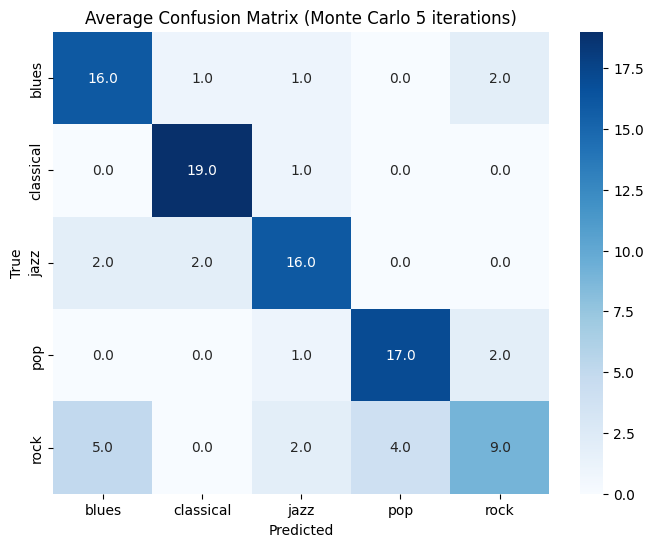

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 假設有五次迭代的結果
all_conf_matrices = []

for iteration in range(5):
    # test_true, test_preds 為該次迭代的真實標籤與預測標籤
    cm = confusion_matrix(test_true, test_preds, labels=genres)
    all_conf_matrices.append(cm)

# 計算平均混淆矩陣
avg_cm = np.mean(all_conf_matrices, axis=0)

plt.figure(figsize=(8,6))
sns.heatmap(avg_cm, annot=True, fmt=".1f", xticklabels=genres, yticklabels=genres, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Average Confusion Matrix (Monte Carlo 5 iterations)")
plt.show()


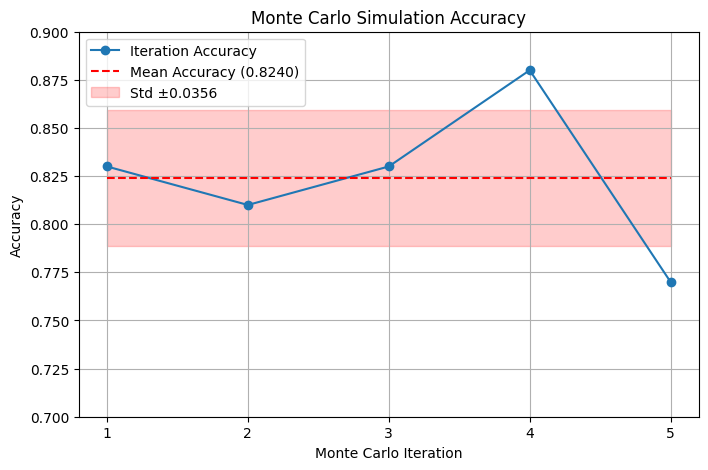

In [10]:
import matplotlib.pyplot as plt

# 假設 acc_scores 已經有五次蒙地卡羅結果
# acc_scores = [0.82, 0.85, 0.80, 0.83, 0.81]

iterations = np.arange(1, len(acc_scores)+1)

mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)

plt.figure(figsize=(8,5))
plt.plot(iterations, acc_scores, marker='o', linestyle='-', label='Iteration Accuracy')
plt.hlines(mean_acc, 1, len(acc_scores), colors='r', linestyles='dashed', label=f'Mean Accuracy ({mean_acc:.4f})')
plt.fill_between(iterations, mean_acc-std_acc, mean_acc+std_acc, color='r', alpha=0.2, label=f'Std ±{std_acc:.4f}')

plt.xticks(iterations)
plt.ylim(0.7, 0.9)
plt.xlabel("Monte Carlo Iteration")
plt.ylabel("Accuracy")
plt.title("Monte Carlo Simulation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### (ZCR + SC + SR + MFCC + Chroma) * (Mean + Variance)

- 類別 : ['blues', 'classical', 'jazz', 'pop', 'rock']
- 樣本數 : 每類各 100 筆，共 499 筆 (jazz 有 1 筆檔案毀損)
- 特徵長度 : 1s
- 切割重疊時長 : 0.5s
- 蒙地卡羅次數 : 5
- 訓練集:測試集 = 8:2

In [20]:
import os
import platform
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
from multiprocessing import cpu_count

# --- 平行運算選擇 ---
if platform.system() == "Windows":
    from multiprocessing.dummy import Pool  # Windows 多執行緒
else:
    from multiprocessing import Pool        # Linux/macOS 多進程

# --- 參數設定 ---
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']

texture_window = 1.0
overlap = 0.5
n_iterations = 5
test_size = 0.2

# === 特徵提取函數 ===
def extract_features_from_segment(y_segment, sr):
    zcr = librosa.feature.zero_crossing_rate(y=y_segment)[0]
    centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)[0]
    mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y_segment, sr=sr)

    return np.hstack([
        np.mean(zcr), np.var(zcr),
        np.mean(centroid), np.var(centroid),
        np.mean(rolloff), np.var(rolloff),
        np.mean(mfcc, axis=1), np.var(mfcc, axis=1),
        np.mean(chroma, axis=1), np.var(chroma, axis=1)
    ])

def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1 - overlap))
    features = []
    for start in range(0, len(y) - texture_samples, hop_samples):
        segment = y[start:start + texture_samples]
        features.append(extract_features_from_segment(segment, sr))
    return np.array(features)

def parallel_feature_extraction(file_label_pairs):
    features, labels = [], []
    for file_path, label in file_label_pairs:
        feats = process_audio_file(file_path)
        for f in feats:
            features.append(f)
            labels.append(label)
    return features, labels

def most_common_label(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

if __name__ == "__main__":
    # --- 預熱 librosa / numba ---
    _ = librosa.hz_to_note(440.0)

    # --- 收集資料集 ---
    all_files, all_labels = [], []
    for genre in genres:
        genre_path = os.path.join(DATASET_PATH, genre)
        files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.wav')]
        all_files.extend(files)
        all_labels.extend([genre] * len(files))

    all_files = np.array(all_files)
    all_labels = np.array(all_labels)
    print(f"Total files: {len(all_files)}")

    acc_scores = []

    # === Monte Carlo 模擬 ===
    for iteration in range(1, n_iterations + 1):
        print(f"\n=== Monte Carlo Iteration {iteration} ===")

        # 分割資料
        train_files, test_files, train_labels, test_labels = train_test_split(
            all_files, all_labels, test_size=test_size, stratify=all_labels, random_state=iteration
        )
        print(f"Training samples: {len(train_files)}, Testing samples: {len(test_files)}")

        # 平行提取訓練特徵
        chunk_size = 5
        train_pairs = list(zip(train_files, train_labels))
        print(f"使用 {cpu_count()} 核心平行提取訓練特徵中...")

        with Pool(processes=cpu_count()) as pool:
            results = list(tqdm(
                pool.imap_unordered(parallel_feature_extraction,
                                    [train_pairs[i:i + chunk_size] for i in range(0, len(train_pairs), chunk_size)]),
                total=max(1, len(train_pairs) // chunk_size)
            ))

        train_features, train_y = [], []
        for f, l in results:
            train_features.extend(f)
            train_y.extend(l)

        X_train = np.array(train_features)
        print(f"訓練特徵矩陣 shape: {X_train.shape}")

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        y_train = np.array(train_y)

        model = LogisticRegression(max_iter=1000, solver='lbfgs')
        model.fit(X_train, y_train)

        # 平行提取測試特徵並以投票方式分類
        test_preds, test_true = [], []
        print(f"Processing test files...")
        pbar = tqdm(test_files, total=len(test_files))
        for fpath in pbar:
            feats = process_audio_file(fpath)
            feats = scaler.transform(feats)
            segment_preds = model.predict(feats)
            song_pred = most_common_label(segment_preds)
            test_preds.append(song_pred)
            # 將檔名和 shape 顯示在進度條右側
            pbar.set_postfix_str(f"{os.path.basename(fpath)} shape: {feats.shape}")
        # 測試標籤
        test_true = list(test_labels)

        acc = accuracy_score(test_true, test_preds)
        acc_scores.append(acc)

        print(f"Iteration {iteration} Accuracy: {acc:.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(test_true, test_preds))
        print("Classification Report:")
        print(classification_report(test_true, test_preds))

    print("\n=== Monte Carlo Summary ===")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Std Accuracy: {np.std(acc_scores):.4f}")


Total files: 499

=== Monte Carlo Iteration 1 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [05:32,  4.15s/it]                         


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


100%|██████████| 100/100 [00:42<00:00,  2.35it/s, jazz.00084.wav shape: (59, 56)]    


Iteration 1 Accuracy: 0.8500
Confusion Matrix:
[[18  0  2  0  0]
 [ 0 19  1  0  0]
 [ 1  1 17  0  1]
 [ 0  0  0 18  2]
 [ 4  0  2  1 13]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.78      0.90      0.84        20
   classical       0.95      0.95      0.95        20
        jazz       0.77      0.85      0.81        20
         pop       0.95      0.90      0.92        20
        rock       0.81      0.65      0.72        20

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100


=== Monte Carlo Iteration 2 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


 25%|██▌       | 20/79 [01:15<00:42,  1.38it/s] c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [04:03,  3.04s/it]                        


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


100%|██████████| 100/100 [01:24<00:00,  1.18it/s, jazz.00033.wav shape: (59, 56)]    


Iteration 2 Accuracy: 0.8400
Confusion Matrix:
[[19  0  0  0  1]
 [ 0 20  0  0  0]
 [ 1  1 16  0  2]
 [ 1  1  0 14  4]
 [ 4  0  0  1 15]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.76      0.95      0.84        20
   classical       0.91      1.00      0.95        20
        jazz       1.00      0.80      0.89        20
         pop       0.93      0.70      0.80        20
        rock       0.68      0.75      0.71        20

    accuracy                           0.84       100
   macro avg       0.86      0.84      0.84       100
weighted avg       0.86      0.84      0.84       100


=== Monte Carlo Iteration 3 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [06:45,  5.07s/it]                         


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


100%|██████████| 100/100 [01:32<00:00,  1.08it/s, classical.00050.wav shape: (59, 56)]


Iteration 3 Accuracy: 0.8700
Confusion Matrix:
[[20  0  0  0  0]
 [ 0 20  0  0  0]
 [ 2  1 17  0  0]
 [ 0  1  1 16  2]
 [ 2  0  3  1 14]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.83      1.00      0.91        20
   classical       0.91      1.00      0.95        20
        jazz       0.81      0.85      0.83        20
         pop       0.94      0.80      0.86        20
        rock       0.88      0.70      0.78        20

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100


=== Monte Carlo Iteration 4 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [05:16,  3.96s/it]                         


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


  5%|▌         | 5/100 [00:07<02:16,  1.44s/it, blues.00050.wav shape: (59, 56)]    c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 100/100 [01:44<00:00,  1.04s/it, blues.00072.wav shape: (59, 56)]   


Iteration 4 Accuracy: 0.8900
Confusion Matrix:
[[19  0  1  0  0]
 [ 0 16  4  0  0]
 [ 1  0 19  0  0]
 [ 1  0  0 17  2]
 [ 2  0  0  0 18]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.83      0.95      0.88        20
   classical       1.00      0.80      0.89        20
        jazz       0.79      0.95      0.86        20
         pop       1.00      0.85      0.92        20
        rock       0.90      0.90      0.90        20

    accuracy                           0.89       100
   macro avg       0.90      0.89      0.89       100
weighted avg       0.90      0.89      0.89       100


=== Monte Carlo Iteration 5 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [03:30,  2.63s/it]                         


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


100%|██████████| 100/100 [00:42<00:00,  2.35it/s, jazz.00026.wav shape: (59, 56)]    

Iteration 5 Accuracy: 0.7900
Confusion Matrix:
[[17  1  0  0  2]
 [ 0 20  0  0  0]
 [ 2  2 16  0  0]
 [ 0  0  0 17  3]
 [ 6  0  1  4  9]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.68      0.85      0.76        20
   classical       0.87      1.00      0.93        20
        jazz       0.94      0.80      0.86        20
         pop       0.81      0.85      0.83        20
        rock       0.64      0.45      0.53        20

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.78       100
weighted avg       0.79      0.79      0.78       100


=== Monte Carlo Summary ===
Mean Accuracy: 0.8480
Std Accuracy: 0.0337


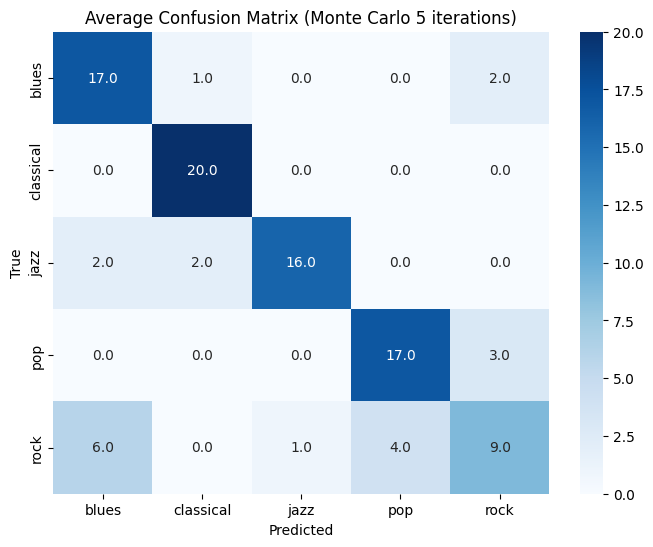

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 假設有五次迭代的結果
all_conf_matrices = []

for iteration in range(5):
    # test_true, test_preds 為該次迭代的真實標籤與預測標籤
    cm = confusion_matrix(test_true, test_preds, labels=genres)
    all_conf_matrices.append(cm)

# 計算平均混淆矩陣
avg_cm = np.mean(all_conf_matrices, axis=0)

plt.figure(figsize=(8,6))
sns.heatmap(avg_cm, annot=True, fmt=".1f", xticklabels=genres, yticklabels=genres, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Average Confusion Matrix (Monte Carlo 5 iterations)")
plt.show()


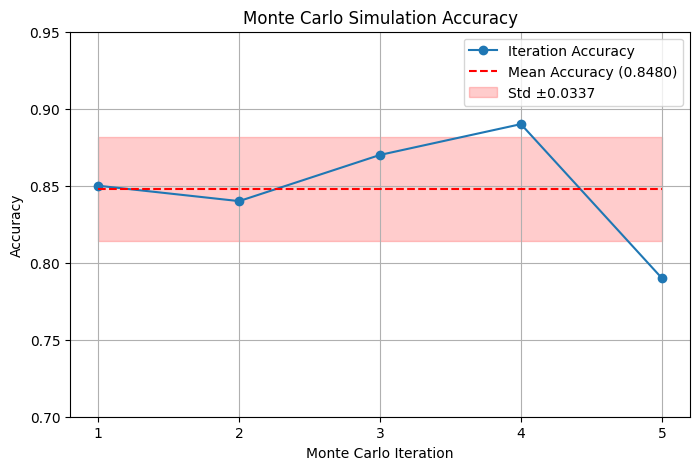

In [22]:
import matplotlib.pyplot as plt

# 假設 acc_scores 已經有五次蒙地卡羅結果
# acc_scores = [0.82, 0.85, 0.80, 0.83, 0.81]

iterations = np.arange(1, len(acc_scores)+1)

mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)

plt.figure(figsize=(8,5))
plt.plot(iterations, acc_scores, marker='o', linestyle='-', label='Iteration Accuracy')
plt.hlines(mean_acc, 1, len(acc_scores), colors='r', linestyles='dashed', label=f'Mean Accuracy ({mean_acc:.4f})')
plt.fill_between(iterations, mean_acc-std_acc, mean_acc+std_acc, color='r', alpha=0.2, label=f'Std ±{std_acc:.4f}')

plt.xticks(iterations)
plt.ylim(0.7, 0.95)
plt.xlabel("Monte Carlo Iteration")
plt.ylabel("Accuracy")
plt.title("Monte Carlo Simulation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### (ZCR + SC + SR + MFCC) * (Mean + Variance) + "standardize Chroma"

- 類別 : ['blues', 'classical', 'jazz', 'pop', 'rock']
- 樣本數 : 每類各 100 筆，共 499 筆 (jazz 有 1 筆檔案毀損)
- 特徵長度 : 1s
- 切割重疊時長 : 0.5s
- 蒙地卡羅次數 : 5
- 訓練集:測試集 = 8:2

In [15]:
import os
import platform
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
from multiprocessing import cpu_count

# --- 平行運算選擇 ---
if platform.system() == "Windows":
    from multiprocessing.dummy import Pool  # Windows 多執行緒
else:
    from multiprocessing import Pool        # Linux/macOS 多進程

# --- 參數設定 ---
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']

texture_window = 1.0
overlap = 0.5
n_iterations = 5
test_size = 0.2

# --- 特徵提取函數 (加入 Chroma + 調性標準化) ---
def extract_features_from_segment(y_segment, sr):
    zcr = librosa.feature.zero_crossing_rate(y=y_segment)[0]
    centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)[0]
    mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
    
    # Chroma 特徵 + 調性標準化到 C
    chroma = librosa.feature.chroma_stft(y=y_segment, sr=sr)
    tonic_index = np.argmax(np.mean(chroma, axis=1))  # 主音位置
    chroma = np.roll(chroma, -tonic_index, axis=0)    # 對齊到 C
    
    return np.hstack([
        np.mean(zcr), np.var(zcr),
        np.mean(centroid), np.var(centroid),
        np.mean(rolloff), np.var(rolloff),
        np.mean(mfcc, axis=1), np.var(mfcc, axis=1),
        np.mean(chroma, axis=1), np.var(chroma, axis=1)
    ])

def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1 - overlap))
    features = []
    for start in range(0, len(y) - texture_samples, hop_samples):
        segment = y[start:start + texture_samples]
        features.append(extract_features_from_segment(segment, sr))
    return np.array(features)

def parallel_feature_extraction(file_label_pairs):
    features, labels = [], []
    for file_path, label in file_label_pairs:
        feats = process_audio_file(file_path)
        for f in feats:
            features.append(f)
            labels.append(label)
    return features, labels

def most_common_label(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

if __name__ == "__main__":
    # --- 預熱 librosa / numba ---
    _ = librosa.hz_to_note(440.0)

    # --- 收集資料集 ---
    all_files, all_labels = [], []
    for genre in genres:
        genre_path = os.path.join(DATASET_PATH, genre)
        files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.wav')]
        all_files.extend(files)
        all_labels.extend([genre] * len(files))

    all_files = np.array(all_files)
    all_labels = np.array(all_labels)
    print(f"Total files: {len(all_files)}")

    acc_scores = []

    # === Monte Carlo 模擬 ===
    for iteration in range(1, n_iterations + 1):
        print(f"\n=== Monte Carlo Iteration {iteration} ===")

        # 分割資料
        train_files, test_files, train_labels, test_labels = train_test_split(
            all_files, all_labels, test_size=test_size, stratify=all_labels, random_state=iteration
        )
        print(f"Training samples: {len(train_files)}, Testing samples: {len(test_files)}")

        # 平行提取訓練特徵
        chunk_size = 5
        train_pairs = list(zip(train_files, train_labels))
        print(f"使用 {cpu_count()} 核心平行提取訓練特徵中...")

        with Pool(processes=cpu_count()) as pool:
            results = list(tqdm(
                pool.imap_unordered(parallel_feature_extraction,
                                    [train_pairs[i:i + chunk_size] for i in range(0, len(train_pairs), chunk_size)]),
                total=max(1, len(train_pairs) // chunk_size)
            ))

        train_features, train_y = [], []
        for f, l in results:
            train_features.extend(f)
            train_y.extend(l)

        X_train = np.array(train_features)
        print(f"訓練特徵矩陣 shape: {X_train.shape}")

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        y_train = np.array(train_y)

        model = LogisticRegression(max_iter=1000, solver='lbfgs')
        model.fit(X_train, y_train)

        # 平行提取測試特徵並以投票方式分類
        test_preds, test_true = [], []
        print(f"Processing test files...")
        pbar = tqdm(test_files, total=len(test_files))
        for fpath in pbar:
            feats = process_audio_file(fpath)
            feats = scaler.transform(feats)
            segment_preds = model.predict(feats)
            song_pred = most_common_label(segment_preds)
            test_preds.append(song_pred)
            # 將檔名和 shape 顯示在進度條右側
            pbar.set_postfix_str(f"{os.path.basename(fpath)} shape: {feats.shape}")
        # 測試標籤
        test_true = list(test_labels)

        acc = accuracy_score(test_true, test_preds)
        acc_scores.append(acc)

        print(f"Iteration {iteration} Accuracy: {acc:.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(test_true, test_preds))
        print("Classification Report:")
        print(classification_report(test_true, test_preds))

    print("\n=== Monte Carlo Summary ===")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Std Accuracy: {np.std(acc_scores):.4f}")

Total files: 499

=== Monte Carlo Iteration 1 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [03:30,  2.64s/it]                         


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


100%|██████████| 100/100 [00:43<00:00,  2.30it/s, jazz.00084.wav shape: (59, 56)]    


Iteration 1 Accuracy: 0.8400
Confusion Matrix:
[[15  0  3  0  2]
 [ 0 20  0  0  0]
 [ 1  1 17  0  1]
 [ 0  0  0 19  1]
 [ 4  0  2  1 13]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.75      0.75      0.75        20
   classical       0.95      1.00      0.98        20
        jazz       0.77      0.85      0.81        20
         pop       0.95      0.95      0.95        20
        rock       0.76      0.65      0.70        20

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100


=== Monte Carlo Iteration 2 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


 25%|██▌       | 20/79 [00:54<00:27,  2.13it/s] c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [03:36,  2.71s/it]                        


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


100%|██████████| 100/100 [00:43<00:00,  2.30it/s, jazz.00033.wav shape: (59, 56)]    


Iteration 2 Accuracy: 0.8400
Confusion Matrix:
[[19  1  0  0  0]
 [ 0 19  1  0  0]
 [ 1  1 17  0  1]
 [ 0  0  1 15  4]
 [ 5  0  1  0 14]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.76      0.95      0.84        20
   classical       0.90      0.95      0.93        20
        jazz       0.85      0.85      0.85        20
         pop       1.00      0.75      0.86        20
        rock       0.74      0.70      0.72        20

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100


=== Monte Carlo Iteration 3 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [03:36,  2.70s/it]                         


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


100%|██████████| 100/100 [00:43<00:00,  2.31it/s, classical.00050.wav shape: (59, 56)]


Iteration 3 Accuracy: 0.8700
Confusion Matrix:
[[20  0  0  0  0]
 [ 0 20  0  0  0]
 [ 1  1 18  0  0]
 [ 0  0  2 16  2]
 [ 3  0  2  2 13]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.83      1.00      0.91        20
   classical       0.95      1.00      0.98        20
        jazz       0.82      0.90      0.86        20
         pop       0.89      0.80      0.84        20
        rock       0.87      0.65      0.74        20

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100


=== Monte Carlo Iteration 4 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [03:36,  2.71s/it]                         


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


  5%|▌         | 5/100 [00:02<00:40,  2.33it/s, blues.00050.wav shape: (59, 56)]    c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 100/100 [00:43<00:00,  2.31it/s, blues.00072.wav shape: (59, 56)]   


Iteration 4 Accuracy: 0.9100
Confusion Matrix:
[[20  0  0  0  0]
 [ 0 18  2  0  0]
 [ 2  0 18  0  0]
 [ 0  0  0 16  4]
 [ 1  0  0  0 19]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.87      1.00      0.93        20
   classical       1.00      0.90      0.95        20
        jazz       0.90      0.90      0.90        20
         pop       1.00      0.80      0.89        20
        rock       0.83      0.95      0.88        20

    accuracy                           0.91       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.92      0.91      0.91       100


=== Monte Carlo Iteration 5 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\py310\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
80it [03:36,  2.71s/it]                         


訓練特徵矩陣 shape: (23538, 56)
Processing test files...


100%|██████████| 100/100 [00:43<00:00,  2.28it/s, jazz.00026.wav shape: (59, 56)]    

Iteration 5 Accuracy: 0.8000
Confusion Matrix:
[[17  1  0  0  2]
 [ 0 18  1  0  1]
 [ 2  1 17  0  0]
 [ 0  0  0 16  4]
 [ 5  0  1  2 12]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.71      0.85      0.77        20
   classical       0.90      0.90      0.90        20
        jazz       0.89      0.85      0.87        20
         pop       0.89      0.80      0.84        20
        rock       0.63      0.60      0.62        20

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100


=== Monte Carlo Summary ===
Mean Accuracy: 0.8520
Std Accuracy: 0.0366


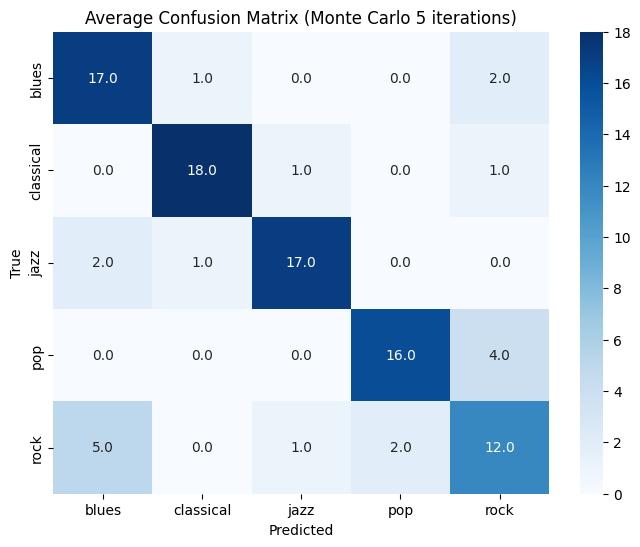

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 假設有五次迭代的結果
all_conf_matrices = []

for iteration in range(5):
    # test_true, test_preds 為該次迭代的真實標籤與預測標籤
    cm = confusion_matrix(test_true, test_preds, labels=genres)
    all_conf_matrices.append(cm)

# 計算平均混淆矩陣
avg_cm = np.mean(all_conf_matrices, axis=0)

plt.figure(figsize=(8,6))
sns.heatmap(avg_cm, annot=True, fmt=".1f", xticklabels=genres, yticklabels=genres, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Average Confusion Matrix (Monte Carlo 5 iterations)")
plt.show()


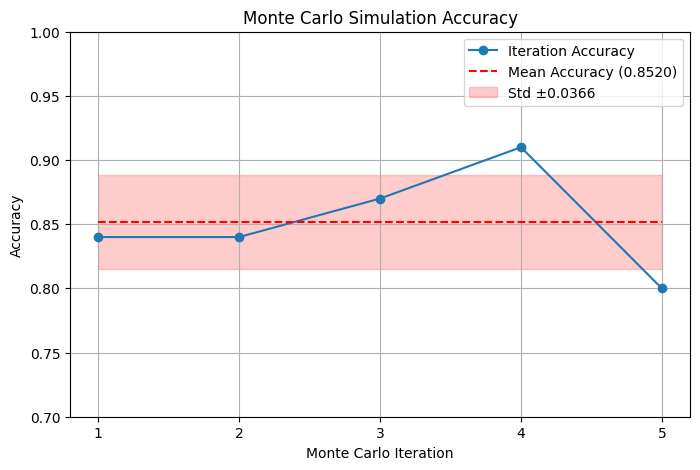

In [17]:
import matplotlib.pyplot as plt

# 假設 acc_scores 已經有五次蒙地卡羅結果
# acc_scores = [0.82, 0.85, 0.80, 0.83, 0.81]

iterations = np.arange(1, len(acc_scores)+1)

mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)

plt.figure(figsize=(8,5))
plt.plot(iterations, acc_scores, marker='o', linestyle='-', label='Iteration Accuracy')
plt.hlines(mean_acc, 1, len(acc_scores), colors='r', linestyles='dashed', label=f'Mean Accuracy ({mean_acc:.4f})')
plt.fill_between(iterations, mean_acc-std_acc, mean_acc+std_acc, color='r', alpha=0.2, label=f'Std ±{std_acc:.4f}')

plt.xticks(iterations)
plt.ylim(0.7, 1)
plt.xlabel("Monte Carlo Iteration")
plt.ylabel("Accuracy")
plt.title("Monte Carlo Simulation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import os
import platform
import warnings
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
from multiprocessing import cpu_count

# 關閉 librosa 警告
warnings.filterwarnings("ignore", category=UserWarning)

# 平行運算
if platform.system() == "Windows":
    from multiprocessing.dummy import Pool  # 多執行緒
else:
    from multiprocessing import Pool        # Linux/macOS 多進程

# --- 參數設定 ---
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']

analysis_window = 0.025  # 分析窗 25 ms
texture_window = 1.0     # 紋理窗 1 s
overlap = 0.5
n_iterations = 5
test_size = 0.2

n_fft = 512
hop_length = 256

# === 特徵提取函數 ===
def extract_analysis_features(y_segment, sr):
    if len(y_segment) < n_fft:
        return np.zeros(6)
    zcr = librosa.feature.zero_crossing_rate(y=y_segment)[0]
    centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
    return np.hstack([
        np.mean(zcr), np.var(zcr),
        np.mean(centroid), np.var(centroid),
        np.mean(rolloff), np.var(rolloff)
    ])

def extract_texture_features(y_texture, sr):
    analysis_samples = int(analysis_window * sr)
    hop_samples = analysis_samples
    analysis_feats = []

    for start in range(0, len(y_texture) - analysis_samples + 1, hop_samples):
        segment = y_texture[start:start+analysis_samples]
        analysis_feats.append(extract_analysis_features(segment, sr))
    if len(analysis_feats) == 0:
        return np.zeros(60)

    analysis_feats = np.array(analysis_feats)
    mean_analysis = np.mean(analysis_feats, axis=0)
    var_analysis = np.var(analysis_feats, axis=0)

    # MFCC
    mfcc = librosa.feature.mfcc(y=y_texture, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_var = np.var(mfcc, axis=1)

    # Chroma + 調性標準化
    chroma = librosa.feature.chroma_stft(y=y_texture, sr=sr, n_fft=n_fft, hop_length=hop_length)
    tonic_index = np.argmax(np.mean(chroma, axis=1))
    chroma = np.roll(chroma, -tonic_index, axis=0)
    chroma_mean = np.mean(chroma, axis=1)
    chroma_var = np.var(chroma, axis=1)

    # ZCR 整段特徵補充
    zcr_full = librosa.feature.zero_crossing_rate(y=y_texture)[0]
    zcr_mean, zcr_var = np.mean(zcr_full), np.var(zcr_full)

    return np.hstack([mean_analysis, var_analysis, [zcr_mean, zcr_var], mfcc_mean, mfcc_var, chroma_mean, chroma_var])

def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1 - overlap))
    features = []
    for start in range(0, len(y) - texture_samples, hop_samples):
        segment = y[start:start + texture_samples]
        features.append(extract_texture_features(segment, sr))
    return np.array(features)

def parallel_feature_extraction(file_label_pairs):
    features, labels = [], []
    for file_path, label in file_label_pairs:
        feats = process_audio_file(file_path)
        for f in feats:
            features.append(f)
            labels.append(label)
    return features, labels

def most_common_label(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

# --- 主程式 ---
if __name__ == "__main__":
    _ = librosa.hz_to_note(440.0)

    # 收集資料
    all_files, all_labels = [], []
    for genre in genres:
        genre_path = os.path.join(DATASET_PATH, genre)
        files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.wav')]
        all_files.extend(files)
        all_labels.extend([genre] * len(files))
    all_files, all_labels = np.array(all_files), np.array(all_labels)
    print(f"Total files: {len(all_files)}")

    acc_scores = []

    for iteration in range(1, n_iterations + 1):
        print(f"\n=== Monte Carlo Iteration {iteration} ===")
        train_files, test_files, train_labels, test_labels = train_test_split(
            all_files, all_labels, test_size=test_size, stratify=all_labels, random_state=iteration
        )
        print(f"Training samples: {len(train_files)}, Testing samples: {len(test_files)}")

        # 平行提取訓練特徵
        chunk_size = 5
        train_pairs = list(zip(train_files, train_labels))
        print(f"使用 {cpu_count()} 核心平行提取訓練特徵中...")

        with Pool(processes=cpu_count()) as pool:
            results = list(tqdm(
                pool.imap_unordered(parallel_feature_extraction,
                                    [train_pairs[i:i + chunk_size] for i in range(0, len(train_pairs), chunk_size)]),
                total=max(1, len(train_pairs) // chunk_size)
            ))

        train_features, train_y = [], []
        for f, l in results:
            train_features.extend(f)
            train_y.extend(l)
        X_train = np.array(train_features)
        print(f"訓練特徵矩陣 shape: {X_train.shape}")

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        y_train = np.array(train_y)

        model = LogisticRegression(max_iter=1000, solver='lbfgs')
        model.fit(X_train, y_train)

        # --- 測試，每首歌投票 ---
        test_preds, test_true = [], []
        pbar = tqdm(test_files, total=len(test_files))
        for fpath, true_label in zip(test_files, test_labels):
            feats = process_audio_file(fpath)
            feats_scaled = scaler.transform(feats)
            segment_preds = model.predict(feats_scaled)
            song_pred = most_common_label(segment_preds)
            test_preds.append(song_pred)
            test_true.append(true_label)
            pbar.set_postfix_str(f"{os.path.basename(fpath)} shape: {feats.shape}")

        acc = accuracy_score(test_true, test_preds)
        acc_scores.append(acc)
        print(f"Iteration {iteration} Accuracy: {acc:.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(test_true, test_preds))
        print("Classification Report:")
        print(classification_report(test_true, test_preds))

    print("\n=== Monte Carlo Summary ===")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Std Accuracy: {np.std(acc_scores):.4f}")


Total files: 499

=== Monte Carlo Iteration 1 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


80it [48:54, 36.68s/it]                           


訓練特徵矩陣 shape: (23538, 64)


  0%|          | 0/100 [03:32<?, ?it/s, jazz.00084.wav shape: (59, 64)]     

Iteration 1 Accuracy: 0.8300
Confusion Matrix:
[[15  0  2  0  3]
 [ 0 20  0  0  0]
 [ 1  1 17  0  1]
 [ 0  0  0 19  1]
 [ 5  0  2  1 12]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.71      0.75      0.73        20
   classical       0.95      1.00      0.98        20
        jazz       0.81      0.85      0.83        20
         pop       0.95      0.95      0.95        20
        rock       0.71      0.60      0.65        20

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100


=== Monte Carlo Iteration 2 ===
Training samples: 399, Testing samples: 100
使用 20 核心平行提取訓練特徵中...


### 新增爵士樂特徵 ( +(ZCR + SC + SR + MFCC) * (Mean + Variance) + "standardize Chroma")

In [9]:
import os
import platform
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
from multiprocessing import cpu_count

# --- 平行運算選擇 ---
if platform.system() == "Windows":
    from multiprocessing.dummy import Pool  # Windows 多執行緒
else:
    from multiprocessing import Pool        # Linux/macOS 多進程

# --- 參數設定 ---
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
genres = ['blues', 'jazz', 'pop']

texture_window = 2.0
overlap = 0.5
n_iterations = 5
test_size = 0.2

# === Swing 特徵提取 ===
def extract_swing_features(y, sr):
    """從音訊片段提取 swing 特徵"""
    try:
        # 節拍與起音偵測
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        onsets = librosa.onset.onset_detect(y=y, sr=sr, units='time')
        if len(onsets) < 3:
            return np.zeros(4)

        # 音符間時間間隔
        intervals = np.diff(onsets)
        ratios = intervals[1:] / (intervals[:-1] + 1e-6)
        swing_ratio = np.mean(ratios)
        swing_var = np.var(ratios)

        # 能量變化
        rms = librosa.feature.rms(y=y)[0]
        rms_mean = np.mean(rms)
        rms_var = np.var(rms)

        return np.array([swing_ratio, swing_var, rms_mean, rms_var])

    except Exception:
        return np.zeros(4)

# === 特徵提取函數 ===
def extract_features_from_segment(y_segment, sr):
    """整合即時與長期特徵 + swing 節奏語法"""
    # --- 即時頻譜特徵 ---
    centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
    #rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)[0]
    #mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)

    # --- ZCR（放在紋理層）---
    #zcr = librosa.feature.zero_crossing_rate(y=y_segment)[0]
    #zcr_mean, zcr_var = np.mean(zcr), np.var(zcr)

    # --- Chroma 特徵 + 調性標準化到 C ---
    #chroma = librosa.feature.chroma_stft(y=y_segment, sr=sr)
    #tonic_index = np.argmax(np.mean(chroma, axis=1))
    #chroma = np.roll(chroma, -tonic_index, axis=0)

    # --- Swing 特徵 ---
    swing_feats = extract_swing_features(y_segment, sr)

    return np.hstack([
        np.mean(centroid), np.var(centroid),
        #np.mean(rolloff), np.var(rolloff),
        #zcr_mean, zcr_var,
        #np.mean(mfcc, axis=1), np.var(mfcc, axis=1),
        #np.mean(chroma, axis=1), np.var(chroma, axis=1),
        swing_feats  # 🎷 新增的 Swing 特徵
    ])

# === 音檔分段與平行處理 ===
def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1 - overlap))
    features = []
    for start in range(0, len(y) - texture_samples, hop_samples):
        segment = y[start:start + texture_samples]
        features.append(extract_features_from_segment(segment, sr))
    return np.array(features)

def parallel_feature_extraction(file_label_pairs):
    features, labels = [], []
    for file_path, label in file_label_pairs:
        feats = process_audio_file(file_path)
        for f in feats:
            features.append(f)
            labels.append(label)
    return features, labels

def most_common_label(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

if __name__ == "__main__":
    _ = librosa.hz_to_note(440.0)  # 預熱 numba

    # --- 收集資料集 ---
    all_files, all_labels = [], []
    for genre in genres:
        genre_path = os.path.join(DATASET_PATH, genre)
        files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.wav')]
        all_files.extend(files)
        all_labels.extend([genre] * len(files))

    all_files = np.array(all_files)
    all_labels = np.array(all_labels)
    print(f"Total files: {len(all_files)}")

    acc_scores = []

    # === Monte Carlo 模擬 ===
    for iteration in range(1, n_iterations + 1):
        print(f"\n=== Monte Carlo Iteration {iteration} ===")

        train_files, test_files, train_labels, test_labels = train_test_split(
            all_files, all_labels, test_size=test_size, stratify=all_labels, random_state=iteration
        )

        print(f"Training samples: {len(train_files)}, Testing samples: {len(test_files)}")

        chunk_size = 5
        train_pairs = list(zip(train_files, train_labels))
        print(f"使用 {cpu_count()} 核心平行提取訓練特徵中...")

        with Pool(processes=cpu_count()) as pool:
            results = list(tqdm(
                pool.imap_unordered(parallel_feature_extraction,
                                    [train_pairs[i:i + chunk_size] for i in range(0, len(train_pairs), chunk_size)]),
                total=max(1, len(train_pairs) // chunk_size)
            ))

        train_features, train_y = [], []
        for f, l in results:
            train_features.extend(f)
            train_y.extend(l)

        X_train = np.array(train_features)
        print(f"訓練特徵矩陣 shape: {X_train.shape}")

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        y_train = np.array(train_y)

        model = LogisticRegression(max_iter=1000, solver='lbfgs')
        model.fit(X_train, y_train)

        # 測試階段（以 segment 投票）
        test_preds, test_true = [], []
        print(f"Processing test files...")
        pbar = tqdm(test_files, total=len(test_files))
        for fpath in pbar:
            feats = process_audio_file(fpath)
            feats = scaler.transform(feats)
            segment_preds = model.predict(feats)
            song_pred = most_common_label(segment_preds)
            test_preds.append(song_pred)
            pbar.set_postfix_str(f"{os.path.basename(fpath)} shape: {feats.shape}")

        test_true = list(test_labels)
        acc = accuracy_score(test_true, test_preds)
        acc_scores.append(acc)

        print(f"Iteration {iteration} Accuracy: {acc:.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(test_true, test_preds))
        print("Classification Report:")
        print(classification_report(test_true, test_preds))

    print("\n=== Monte Carlo Summary ===")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Std Accuracy: {np.std(acc_scores):.4f}")


Total files: 299

=== Monte Carlo Iteration 1 ===
Training samples: 239, Testing samples: 60
使用 20 核心平行提取訓練特徵中...


48it [02:27,  3.07s/it]                        


訓練特徵矩陣 shape: (6931, 6)
Processing test files...


100%|██████████| 60/60 [00:21<00:00,  2.77it/s, jazz.00077.wav shape: (29, 6)] 


Iteration 1 Accuracy: 0.6000
Confusion Matrix:
[[ 5 13  2]
 [ 2 15  3]
 [ 1  3 16]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.62      0.25      0.36        20
        jazz       0.48      0.75      0.59        20
         pop       0.76      0.80      0.78        20

    accuracy                           0.60        60
   macro avg       0.62      0.60      0.58        60
weighted avg       0.62      0.60      0.58        60


=== Monte Carlo Iteration 2 ===
Training samples: 239, Testing samples: 60
使用 20 核心平行提取訓練特徵中...


48it [02:34,  3.21s/it]                        


訓練特徵矩陣 shape: (6931, 6)
Processing test files...


100%|██████████| 60/60 [00:23<00:00,  2.60it/s, jazz.00064.wav shape: (29, 6)] 


Iteration 2 Accuracy: 0.6000
Confusion Matrix:
[[10 10  0]
 [ 9 11  0]
 [ 1  4 15]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.50      0.50      0.50        20
        jazz       0.44      0.55      0.49        20
         pop       1.00      0.75      0.86        20

    accuracy                           0.60        60
   macro avg       0.65      0.60      0.62        60
weighted avg       0.65      0.60      0.62        60


=== Monte Carlo Iteration 3 ===
Training samples: 239, Testing samples: 60
使用 20 核心平行提取訓練特徵中...


48it [02:34,  3.22s/it]                        


訓練特徵矩陣 shape: (6931, 6)
Processing test files...


100%|██████████| 60/60 [00:22<00:00,  2.71it/s, pop.00021.wav shape: (29, 6)]  


Iteration 3 Accuracy: 0.7167
Confusion Matrix:
[[13  7  0]
 [ 8 11  1]
 [ 0  1 19]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.62      0.65      0.63        20
        jazz       0.58      0.55      0.56        20
         pop       0.95      0.95      0.95        20

    accuracy                           0.72        60
   macro avg       0.72      0.72      0.72        60
weighted avg       0.72      0.72      0.72        60


=== Monte Carlo Iteration 4 ===
Training samples: 239, Testing samples: 60
使用 20 核心平行提取訓練特徵中...


48it [02:37,  3.28s/it]                        


訓練特徵矩陣 shape: (6931, 6)
Processing test files...


100%|██████████| 60/60 [00:21<00:00,  2.73it/s, blues.00098.wav shape: (29, 6)]


Iteration 4 Accuracy: 0.7333
Confusion Matrix:
[[12  8  0]
 [ 7 13  0]
 [ 1  0 19]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.60      0.60      0.60        20
        jazz       0.62      0.65      0.63        20
         pop       1.00      0.95      0.97        20

    accuracy                           0.73        60
   macro avg       0.74      0.73      0.74        60
weighted avg       0.74      0.73      0.74        60


=== Monte Carlo Iteration 5 ===
Training samples: 239, Testing samples: 60
使用 20 核心平行提取訓練特徵中...


48it [02:02,  2.55s/it]                        


訓練特徵矩陣 shape: (6931, 6)
Processing test files...


100%|██████████| 60/60 [00:30<00:00,  1.97it/s, pop.00051.wav shape: (29, 6)]  

Iteration 5 Accuracy: 0.6167
Confusion Matrix:
[[10  9  1]
 [ 7 12  1]
 [ 2  3 15]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.53      0.50      0.51        20
        jazz       0.50      0.60      0.55        20
         pop       0.88      0.75      0.81        20

    accuracy                           0.62        60
   macro avg       0.64      0.62      0.62        60
weighted avg       0.64      0.62      0.62        60


=== Monte Carlo Summary ===
Mean Accuracy: 0.6533
Std Accuracy: 0.0591


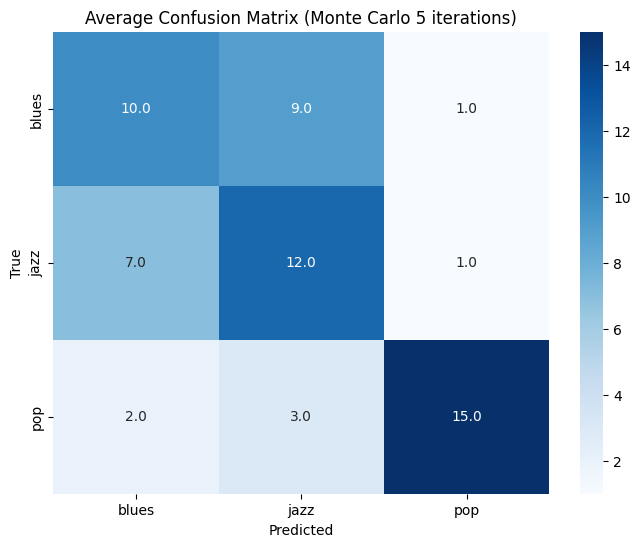

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 假設有五次迭代的結果
all_conf_matrices = []

for iteration in range(5):
    # test_true, test_preds 為該次迭代的真實標籤與預測標籤
    cm = confusion_matrix(test_true, test_preds, labels=genres)
    all_conf_matrices.append(cm)

# 計算平均混淆矩陣
avg_cm = np.mean(all_conf_matrices, axis=0)

plt.figure(figsize=(8,6))
sns.heatmap(avg_cm, annot=True, fmt=".1f", xticklabels=genres, yticklabels=genres, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Average Confusion Matrix (Monte Carlo 5 iterations)")
plt.show()


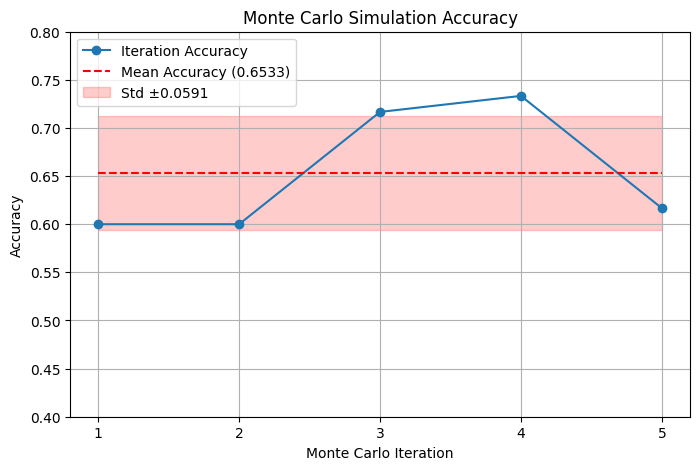

In [11]:
import matplotlib.pyplot as plt

# 假設 acc_scores 已經有五次蒙地卡羅結果
# acc_scores = [0.82, 0.85, 0.80, 0.83, 0.81]

iterations = np.arange(1, len(acc_scores)+1)

mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)

plt.figure(figsize=(8,5))
plt.plot(iterations, acc_scores, marker='o', linestyle='-', label='Iteration Accuracy')
plt.hlines(mean_acc, 1, len(acc_scores), colors='r', linestyles='dashed', label=f'Mean Accuracy ({mean_acc:.4f})')
plt.fill_between(iterations, mean_acc-std_acc, mean_acc+std_acc, color='r', alpha=0.2, label=f'Std ±{std_acc:.4f}')

plt.xticks(iterations)
plt.ylim(0.4, 0.8)
plt.xlabel("Monte Carlo Iteration")
plt.ylabel("Accuracy")
plt.title("Monte Carlo Simulation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### DWCH 特徵測試

In [5]:
import os
import platform
import librosa
import numpy as np
import pywt
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
from multiprocessing import cpu_count

# --- 平行運算選擇 ---
if platform.system() == "Windows":
    from multiprocessing.dummy import Pool  # Windows 多執行緒
else:
    from multiprocessing import Pool        # Linux/macOS 多進程

# --- 參數設定 ---
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\test"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']

texture_window = 2.0
overlap = 0.5
n_iterations = 5
test_size = 0.3

# === Swing 特徵 ===
def extract_swing_features(y, sr):
    """從音訊片段提取 swing 特徵"""
    try:
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        onsets = librosa.onset.onset_detect(y=y, sr=sr, units='time')
        if len(onsets) < 3:
            return np.zeros(4)
        intervals = np.diff(onsets)
        ratios = intervals[1:] / (intervals[:-1] + 1e-6)
        swing_ratio = np.mean(ratios)
        swing_var = np.var(ratios)
        rms = librosa.feature.rms(y=y)[0]
        rms_mean = np.mean(rms)
        rms_var = np.var(rms)
        return np.array([swing_ratio, swing_var, rms_mean, rms_var])
    except Exception:
        return np.zeros(4)

# === DWCH 特徵 ===
def extract_DWCH_features(y, wavelet='db4', level=4):
    """提取 DWCH 特徵：多層小波分解 + 直方圖統計"""
    try:
        coeffs = pywt.wavedec(y, wavelet=wavelet, level=level)
        feature_vector = []
        for band in coeffs:
            band = np.nan_to_num(band)
            hist, _ = np.histogram(band, bins=20, density=True)
            mean_val = np.mean(band)
            var_val = np.var(band)
            skew_val = skew(band)
            energy_val = np.sum(band ** 2)
            band_features = np.concatenate(([mean_val, var_val, skew_val, energy_val], hist))
            feature_vector.extend(band_features)
        return np.array(feature_vector)
    except Exception:
        return np.zeros(4 + 20 * level)  # 預設長度防錯

# === 特徵整合 ===
def extract_features_from_segment(y_segment, sr):
    """整合 Swing + DWCH 特徵"""
    try:
        centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
        #swing_feats = extract_swing_features(y_segment, sr)
        dwch_feats = extract_DWCH_features(y_segment)
        return np.hstack([
            np.mean(centroid), np.var(centroid),
            #swing_feats,
            dwch_feats
        ])
    except Exception:
        return np.zeros(2 + 4 + 100)  # 防止錯誤導致維度不一致

# === 音檔分段與平行處理 ===
def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1 - overlap))
    features = []
    for start in range(0, len(y) - texture_samples, hop_samples):
        segment = y[start:start + texture_samples]
        features.append(extract_features_from_segment(segment, sr))
    return np.array(features)

def parallel_feature_extraction(file_label_pairs):
    features, labels = [], []
    for file_path, label in file_label_pairs:
        feats = process_audio_file(file_path)
        for f in feats:
            features.append(f)
            labels.append(label)
    return features, labels

def most_common_label(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

# === 主程式 ===
if __name__ == "__main__":
    _ = librosa.hz_to_note(440.0)  # 預熱 numba

    # 收集資料
    all_files, all_labels = [], []
    for genre in genres:
        genre_path = os.path.join(DATASET_PATH, genre)
        files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.wav')]
        all_files.extend(files)
        all_labels.extend([genre] * len(files))

    all_files = np.array(all_files)
    all_labels = np.array(all_labels)
    print(f"Total files: {len(all_files)}")

    acc_scores = []

    # Monte Carlo 模擬
    for iteration in range(1, n_iterations + 1):
        print(f"\n=== Monte Carlo Iteration {iteration} ===")

        train_files, test_files, train_labels, test_labels = train_test_split(
            all_files, all_labels, test_size=test_size, stratify=all_labels, random_state=iteration
        )

        print(f"Training samples: {len(train_files)}, Testing samples: {len(test_files)}")

        chunk_size = 5
        train_pairs = list(zip(train_files, train_labels))
        print(f"使用 {cpu_count()} 核心平行提取訓練特徵中...")

        with Pool(processes=cpu_count()) as pool:
            results = list(tqdm(
                pool.imap_unordered(parallel_feature_extraction,
                                    [train_pairs[i:i + chunk_size] for i in range(0, len(train_pairs), chunk_size)]),
                total=max(1, len(train_pairs) // chunk_size)
            ))

        train_features, train_y = [], []
        for f, l in results:
            train_features.extend(f)
            train_y.extend(l)

        X_train = np.array(train_features)
        print(f"訓練特徵矩陣 shape: {X_train.shape}")

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        y_train = np.array(train_y)

        model = LogisticRegression(max_iter=1000, solver='lbfgs')
        model.fit(X_train, y_train)

        # 測試階段
        test_preds, test_true = [], []
        print(f"Processing test files...")
        pbar = tqdm(test_files, total=len(test_files))
        for fpath in pbar:
            feats = process_audio_file(fpath)
            feats = scaler.transform(feats)
            segment_preds = model.predict(feats)
            song_pred = most_common_label(segment_preds)
            test_preds.append(song_pred)
            pbar.set_postfix_str(f"{os.path.basename(fpath)} shape: {feats.shape}")

        test_true = list(test_labels)
        acc = accuracy_score(test_true, test_preds)
        acc_scores.append(acc)

        print(f"Iteration {iteration} Accuracy: {acc:.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(test_true, test_preds))
        print("Classification Report:")
        print(classification_report(test_true, test_preds))

    print("\n=== Monte Carlo Summary ===")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Std Accuracy: {np.std(acc_scores):.4f}")


Total files: 150

=== Monte Carlo Iteration 1 ===
Training samples: 105, Testing samples: 45
使用 20 核心平行提取訓練特徵中...


100%|██████████| 21/21 [00:15<00:00,  1.35it/s]


訓練特徵矩陣 shape: (3044, 122)
Processing test files...


100%|██████████| 45/45 [00:05<00:00,  7.84it/s, pop.00006.wav shape: (29, 122)]      


Iteration 1 Accuracy: 0.8889
Confusion Matrix:
[[6 0 0 1 2]
 [0 9 0 0 0]
 [0 0 9 0 0]
 [0 0 0 9 0]
 [1 0 0 1 7]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.86      0.67      0.75         9
   classical       1.00      1.00      1.00         9
        jazz       1.00      1.00      1.00         9
         pop       0.82      1.00      0.90         9
        rock       0.78      0.78      0.78         9

    accuracy                           0.89        45
   macro avg       0.89      0.89      0.89        45
weighted avg       0.89      0.89      0.89        45


=== Monte Carlo Iteration 2 ===
Training samples: 105, Testing samples: 45
使用 20 核心平行提取訓練特徵中...


100%|██████████| 21/21 [00:14<00:00,  1.42it/s]


訓練特徵矩陣 shape: (3044, 122)
Processing test files...


100%|██████████| 45/45 [00:05<00:00,  8.17it/s, rock.00015.wav shape: (29, 122)]     


Iteration 2 Accuracy: 0.8667
Confusion Matrix:
[[7 0 0 1 1]
 [0 9 0 0 0]
 [0 1 7 0 1]
 [0 0 1 8 0]
 [1 0 0 0 8]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.88      0.78      0.82         9
   classical       0.90      1.00      0.95         9
        jazz       0.88      0.78      0.82         9
         pop       0.89      0.89      0.89         9
        rock       0.80      0.89      0.84         9

    accuracy                           0.87        45
   macro avg       0.87      0.87      0.87        45
weighted avg       0.87      0.87      0.87        45


=== Monte Carlo Iteration 3 ===
Training samples: 105, Testing samples: 45
使用 20 核心平行提取訓練特徵中...


100%|██████████| 21/21 [00:16<00:00,  1.31it/s]


訓練特徵矩陣 shape: (3045, 122)
Processing test files...


100%|██████████| 45/45 [00:05<00:00,  8.17it/s, pop.00022.wav shape: (29, 122)]      


Iteration 3 Accuracy: 0.8222
Confusion Matrix:
[[7 0 0 0 2]
 [0 9 0 0 0]
 [0 2 7 0 0]
 [1 0 0 6 2]
 [0 0 0 1 8]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.88      0.78      0.82         9
   classical       0.82      1.00      0.90         9
        jazz       1.00      0.78      0.88         9
         pop       0.86      0.67      0.75         9
        rock       0.67      0.89      0.76         9

    accuracy                           0.82        45
   macro avg       0.84      0.82      0.82        45
weighted avg       0.84      0.82      0.82        45


=== Monte Carlo Iteration 4 ===
Training samples: 105, Testing samples: 45
使用 20 核心平行提取訓練特徵中...


100%|██████████| 21/21 [00:15<00:00,  1.38it/s]


訓練特徵矩陣 shape: (3044, 122)
Processing test files...


100%|██████████| 45/45 [00:05<00:00,  8.35it/s, pop.00021.wav shape: (29, 122)]      


Iteration 4 Accuracy: 0.8000
Confusion Matrix:
[[7 0 0 0 2]
 [0 9 0 0 0]
 [1 1 7 0 0]
 [0 0 1 7 1]
 [2 0 0 1 6]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.70      0.78      0.74         9
   classical       0.90      1.00      0.95         9
        jazz       0.88      0.78      0.82         9
         pop       0.88      0.78      0.82         9
        rock       0.67      0.67      0.67         9

    accuracy                           0.80        45
   macro avg       0.80      0.80      0.80        45
weighted avg       0.80      0.80      0.80        45


=== Monte Carlo Iteration 5 ===
Training samples: 105, Testing samples: 45
使用 20 核心平行提取訓練特徵中...


100%|██████████| 21/21 [00:15<00:00,  1.34it/s]


訓練特徵矩陣 shape: (3044, 122)
Processing test files...


100%|██████████| 45/45 [00:31<00:00,  1.42it/s, classical.00001.wav shape: (29, 122)]

Iteration 5 Accuracy: 0.8444
Confusion Matrix:
[[7 0 1 0 1]
 [0 9 0 0 0]
 [0 1 7 1 0]
 [0 0 1 7 1]
 [1 0 0 0 8]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.88      0.78      0.82         9
   classical       0.90      1.00      0.95         9
        jazz       0.78      0.78      0.78         9
         pop       0.88      0.78      0.82         9
        rock       0.80      0.89      0.84         9

    accuracy                           0.84        45
   macro avg       0.85      0.84      0.84        45
weighted avg       0.85      0.84      0.84        45


=== Monte Carlo Summary ===
Mean Accuracy: 0.8444
Std Accuracy: 0.0314


In [ ]:
import os
import platform
import librosa
import numpy as np
import pywt
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
from multiprocessing import cpu_count

# --- 平行運算選擇 ---
if platform.system() == "Windows":
    from multiprocessing.dummy import Pool  # Windows 多執行緒
else:
    from multiprocessing import Pool        # Linux/macOS 多進程

# --- 參數設定 ---
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\test"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']

texture_window = 2.0
overlap = 0.5
n_iterations = 1
test_size = 0.3

analysis_window = 0.1  # 分析窗：50 毫秒
analysis_hop = 0.05    # 分析窗移動：25 毫秒
n_analysis_windows = 20  # 每個 texture window 隨機取 20 個 analysis window

# === Swing 特徵 ===
def extract_swing_features(y, sr):
    """從音訊片段提取 swing 特徵"""
    try:
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        onsets = librosa.onset.onset_detect(y=y, sr=sr, units='time')
        if len(onsets) < 3:
            return np.zeros(4)
        intervals = np.diff(onsets)
        ratios = intervals[1:] / (intervals[:-1] + 1e-6)
        swing_ratio = np.mean(ratios)
        swing_var = np.var(ratios)
        rms = librosa.feature.rms(y=y)[0]
        rms_mean = np.mean(rms)
        rms_var = np.var(rms)
        return np.array([swing_ratio, swing_var, rms_mean, rms_var])
    except Exception:
        return np.zeros(4)

# === DWCH 特徵 ===
def extract_DWCH_features(y, wavelet='db4', level=4):
    """提取 DWCH 特徵：多層小波分解 + 直方圖統計"""
    try:
        coeffs = pywt.wavedec(y, wavelet=wavelet, level=level)
        feature_vector = []
        for band in coeffs:
            band = np.nan_to_num(band)
            hist, _ = np.histogram(band, bins=20, density=True)
            mean_val = np.mean(band)
            var_val = np.var(band)
            skew_val = skew(band)
            energy_val = np.sum(band ** 2)
            band_features = np.concatenate(([mean_val, var_val, skew_val, energy_val], hist))
            feature_vector.extend(band_features)
        return np.array(feature_vector)
    except Exception:
        return np.zeros(4 + 20 * level)  # 預設長度防錯


# === Analysis window 特徵提取 ===
def extract_analysis_features(y_segment, sr):
    """計算單個 analysis window 的短期特徵"""
    if len(y_segment) < int(0.02 * sr):  # 小於 20ms 的音訊忽略
        return np.zeros(6 + 13*2 + 12*2 + len(extract_swing_features(y_segment, sr)) + len(extract_DWCH_features(y_segment)))

    centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)[0]
    zcr = librosa.feature.zero_crossing_rate(y=y_segment)[0]
    mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y_segment, sr=sr)

    # 調性標準化
    tonic_index = np.argmax(np.mean(chroma, axis=1))
    chroma = np.roll(chroma, -tonic_index, axis=0)

    # === 統計分析窗的特徵 ===
    feats = [
        np.mean(centroid), np.var(centroid),
        np.mean(rolloff), np.var(rolloff),
        np.mean(zcr), np.var(zcr),
        *np.mean(mfcc, axis=1), *np.var(mfcc, axis=1),
        *np.mean(chroma, axis=1), *np.var(chroma, axis=1),
        *extract_swing_features(y_segment, sr),
        *extract_DWCH_features(y_segment)
    ]
    return np.array(feats)


# === Texture window 特徵提取 ===
def extract_features_from_segment(y_segment, sr):
    """在 texture window 內隨機取 20 個 analysis window，並彙整統計特徵"""
    analysis_len = int(analysis_window * sr)
    total_len = len(y_segment)

    # 若音訊太短，不足以取樣
    if total_len < analysis_len:
        dummy_feats = extract_analysis_features(y_segment, sr)
        return np.hstack([dummy_feats, dummy_feats * 0])

    # --- 隨機選取起始點 ---
    max_start = total_len - analysis_len
    starts = np.random.randint(0, max_start, size=n_analysis_windows)

    analysis_features = []
    for start in starts:
        subseg = y_segment[start:start + analysis_len]
        feats = extract_analysis_features(subseg, sr)
        analysis_features.append(feats)

    analysis_features = np.array(analysis_features)

    # --- 若特徵數太少仍補0防止報錯 ---
    if analysis_features.shape[0] == 0:
        return np.zeros(len(extract_analysis_features(y_segment, sr)) * 2)

    # --- 統計分析 ---
    texture_mean = np.mean(analysis_features, axis=0)
    texture_var = np.var(analysis_features, axis=0)

    return np.hstack([texture_mean, texture_var])


# === 音檔處理 ===
def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1 - overlap))
    features = []

    for start in range(0, len(y) - texture_samples, hop_samples):
        segment = y[start:start + texture_samples]
        features.append(extract_features_from_segment(segment, sr))

    return np.array(features)


def parallel_feature_extraction(file_label_pairs):
    features, labels = [], []
    for file_path, label in file_label_pairs:
        feats = process_audio_file(file_path)
        for f in feats:
            features.append(f)
            labels.append(label)
    return features, labels

def most_common_label(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

# === 主程式 ===
if __name__ == "__main__":
    _ = librosa.hz_to_note(440.0)  # 預熱 numba

    # 收集資料
    all_files, all_labels = [], []
    for genre in genres:
        genre_path = os.path.join(DATASET_PATH, genre)
        files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.wav')]
        all_files.extend(files)
        all_labels.extend([genre] * len(files))

    all_files = np.array(all_files)
    all_labels = np.array(all_labels)
    print(f"Total files: {len(all_files)}")

    acc_scores = []

    # Monte Carlo 模擬
    for iteration in range(1, n_iterations + 1):
        print(f"\n=== Monte Carlo Iteration {iteration} ===")

        train_files, test_files, train_labels, test_labels = train_test_split(
            all_files, all_labels, test_size=test_size, stratify=all_labels, random_state=iteration
        )

        print(f"Training samples: {len(train_files)}, Testing samples: {len(test_files)}")

        chunk_size = 5
        train_pairs = list(zip(train_files, train_labels))
        print(f"使用 {cpu_count()} 核心平行提取訓練特徵中...")

        with Pool(processes=cpu_count()) as pool:
            results = list(tqdm(
                pool.imap_unordered(parallel_feature_extraction,
                                    [train_pairs[i:i + chunk_size] for i in range(0, len(train_pairs), chunk_size)]),
                total=max(1, len(train_pairs) // chunk_size)
            ))

        train_features, train_y = [], []
        for f, l in results:
            train_features.extend(f)
            train_y.extend(l)

        X_train = np.array(train_features)
        print(f"訓練特徵矩陣 shape: {X_train.shape}")

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        y_train = np.array(train_y)

        model = LogisticRegression(max_iter=1000, solver='lbfgs')
        model.fit(X_train, y_train)

        # 測試階段
        test_preds, test_true = [], []
        print(f"Processing test files...")
        pbar = tqdm(test_files, total=len(test_files))
        for fpath in pbar:
            feats = process_audio_file(fpath)
            feats = scaler.transform(feats)
            segment_preds = model.predict(feats)
            song_pred = most_common_label(segment_preds)
            test_preds.append(song_pred)
            pbar.set_postfix_str(f"{os.path.basename(fpath)} shape: {feats.shape}")

        test_true = list(test_labels)
        acc = accuracy_score(test_true, test_preds)
        acc_scores.append(acc)

        print(f"Iteration {iteration} Accuracy: {acc:.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(test_true, test_preds))
        print("Classification Report:")
        print(classification_report(test_true, test_preds))

    print("\n=== Monte Carlo Summary ===")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Std Accuracy: {np.std(acc_scores):.4f}")


Total files: 150

=== Monte Carlo Iteration 1 ===
Training samples: 105, Testing samples: 45
使用 20 核心平行提取訓練特徵中...


100%|██████████| 21/21 [03:02<00:00,  8.67s/it]


訓練特徵矩陣 shape: (3044, 12)
Processing test files...


100%|██████████| 45/45 [03:21<00:00,  4.48s/it, pop.00006.wav shape: (29, 12)]      

Iteration 1 Accuracy: 0.6889
Confusion Matrix:
[[4 0 2 1 2]
 [0 9 0 0 0]
 [3 0 5 0 1]
 [0 0 0 9 0]
 [2 1 1 1 4]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.44      0.44      0.44         9
   classical       0.90      1.00      0.95         9
        jazz       0.62      0.56      0.59         9
         pop       0.82      1.00      0.90         9
        rock       0.57      0.44      0.50         9

    accuracy                           0.69        45
   macro avg       0.67      0.69      0.68        45
weighted avg       0.67      0.69      0.68        45


=== Monte Carlo Summary ===
Mean Accuracy: 0.6889
Std Accuracy: 0.0000


### 新增 PCA流程 (取 PC11~PC3)

In [48]:
import os
import platform
import librosa
import numpy as np
import pywt
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
from multiprocessing import cpu_count

# --- 平行運算選擇 ---
if platform.system() == "Windows":
    from multiprocessing.dummy import Pool  # Windows 多執行緒
else:
    from multiprocessing import Pool        # Linux/macOS 多進程

# --- 參數設定 ---
DATASET_PATH = "C:\\Users\\user\\Desktop\\碩士二年級\\Python\\論文CODE\\Data\\genres_original"
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']

texture_window = 2.0
overlap = 0.5
n_iterations = 5
test_size = 0.2

analysis_window = 0.1  # 分析窗
analysis_hop = 0.05
n_analysis_windows = 20

# === Swing 特徵 ===
def extract_swing_features(y, sr):
    try:
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        onsets = librosa.onset.onset_detect(y=y, sr=sr, units='time')
        if len(onsets) < 3:
            return np.zeros(4)
        intervals = np.diff(onsets)
        ratios = intervals[1:] / (intervals[:-1] + 1e-6)
        swing_ratio = np.mean(ratios)
        swing_var = np.var(ratios)
        rms = librosa.feature.rms(y=y)[0]
        rms_mean = np.mean(rms)
        rms_var = np.var(rms)
        return np.array([swing_ratio, swing_var, rms_mean, rms_var])
    except Exception:
        return np.zeros(4)

# === DWCH 特徵 ===
def extract_DWCH_features(y, wavelet='db4', level=4):
    try:
        coeffs = pywt.wavedec(y, wavelet=wavelet, level=level)
        feature_vector = []
        for band in coeffs:
            band = np.nan_to_num(band)
            hist, _ = np.histogram(band, bins=20, density=True)
            mean_val = np.mean(band)
            var_val = np.var(band)
            skew_val = skew(band)
            energy_val = np.sum(band ** 2)
            band_features = np.concatenate(([mean_val, var_val, skew_val, energy_val], hist))
            feature_vector.extend(band_features)
        return np.array(feature_vector)
    except Exception:
        return np.zeros(4 + 20 * level)

# === Analysis window 特徵 ===
def extract_analysis_features(y_segment, sr):
    if len(y_segment) < int(0.02 * sr):
        return np.zeros(6 + 13*2 + 12*2 + 4 + (4 + 20*4))
    centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)[0]
    zcr = librosa.feature.zero_crossing_rate(y=y_segment)[0]
    mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
    # chroma = librosa.feature.chroma_stft(y=y_segment, sr=sr)
    # tonic_index = np.argmax(np.mean(chroma, axis=1))
    # chroma = np.roll(chroma, -tonic_index, axis=0)
    feats = [
        np.mean(centroid), np.var(centroid),
        np.mean(rolloff), np.var(rolloff),
        np.mean(zcr), np.var(zcr),
        *np.mean(mfcc, axis=1), *np.var(mfcc, axis=1),
        # *np.mean(chroma, axis=1), *np.var(chroma, axis=1),
        *extract_swing_features(y_segment, sr),
        # *extract_DWCH_features(y_segment)
    ]
    return np.array(feats)

# === Texture window 特徵 ===
# def extract_features_from_segment(y_segment, sr):
#     analysis_len = int(analysis_window * sr)
#     total_len = len(y_segment)
#     if total_len < analysis_len:
#         dummy_feats = extract_analysis_features(y_segment, sr)
#         return np.hstack([dummy_feats, dummy_feats * 0])
#     max_start = total_len - analysis_len
#     starts = np.random.randint(0, max_start, size=n_analysis_windows)
#     analysis_features = []
#     for start in starts:
#         subseg = y_segment[start:start + analysis_len]
#         feats = extract_analysis_features(subseg, sr)
#         analysis_features.append(feats)
#     analysis_features = np.array(analysis_features)
#     if analysis_features.shape[0] == 0:
#         return np.zeros(len(extract_analysis_features(y_segment, sr)) * 2)
#     texture_mean = np.mean(analysis_features, axis=0)
#     texture_var = np.var(analysis_features, axis=0)
#     return np.hstack([texture_mean, texture_var])

def extract_features_from_segment(y_segment, sr):
    """
    在每個 texture window 內，每 0.5 秒取一個長度為 0.1 秒的 analysis window（其餘 0.4 秒不取）。
    對所有取得的 analysis windows 計算分析特徵，然後回傳 mean + var。
    """
    analysis_len = int(analysis_window * sr)   # 0.1 秒 → 樣本數
    hop_len = int(0.5 * sr)                    # 每 0.5 秒取一次
    total_len = len(y_segment)

    # 若片段太短，直接用 single-window 的 fallback（與原先一致）
    if total_len < analysis_len:
        dummy_feats = extract_analysis_features(y_segment, sr)
        return np.hstack([dummy_feats, dummy_feats * 0])

    # 產生起始點：0, 0.5s, 1.0s, ...
    starts = np.arange(0, total_len - analysis_len + 1, hop_len, dtype=int)

    analysis_features = []
    for start in starts:
        subseg = y_segment[start:start + analysis_len]
        feats = extract_analysis_features(subseg, sr)
        analysis_features.append(feats)

    analysis_features = np.array(analysis_features)

    # 若沒有成功擷取任何 analysis window，回傳 zeros（防止後續錯誤）
    if analysis_features.shape[0] == 0:
        return np.zeros(len(extract_analysis_features(y_segment, sr)) * 2)

    texture_mean = np.mean(analysis_features, axis=0)
    texture_var = np.var(analysis_features, axis=0)

    return np.hstack([texture_mean, texture_var])

# === 音檔處理 ===
def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    texture_samples = int(texture_window * sr)
    hop_samples = int(texture_samples * (1 - overlap))
    features = []
    for start in range(0, len(y) - texture_samples, hop_samples):
        segment = y[start:start + texture_samples]
        features.append(extract_features_from_segment(segment, sr))
    return np.array(features)

# === 平行提取 ===
def parallel_feature_extraction(file_label_pairs):
    features, labels = [], []
    for file_path, label in file_label_pairs:
        feats = process_audio_file(file_path)
        for f in feats:
            features.append(f)
            labels.append(label)
    return features, labels

def most_common_label(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

# === 主程式 ===
if __name__ == "__main__":
    _ = librosa.hz_to_note(440.0)
    all_files, all_labels = [], []
    for genre in genres:
        genre_path = os.path.join(DATASET_PATH, genre)
        files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.wav')]
        all_files.extend(files)
        all_labels.extend([genre] * len(files))

    all_files = np.array(all_files)
    all_labels = np.array(all_labels)
    print(f"Total files: {len(all_files)}")

    acc_scores = []

    for iteration in range(1, n_iterations + 1):
        print(f"\n=== Monte Carlo Iteration {iteration} ===")

        train_files, test_files, train_labels, test_labels = train_test_split(
            all_files, all_labels, test_size=test_size, stratify=all_labels, random_state=iteration
        )

        print(f"Training samples: {len(train_files)}, Testing samples: {len(test_files)}")

        # === 提取訓練特徵 ===
        chunk_size = 10
        train_pairs = list(zip(train_files, train_labels))
        with Pool(processes=cpu_count()) as pool:
            results = list(tqdm(
                pool.imap_unordered(parallel_feature_extraction,
                                    [train_pairs[i:i + chunk_size] for i in range(0, len(train_pairs), chunk_size)]),
                total=max(1, len(train_pairs) // chunk_size)
            ))
        train_features, train_y = [], []
        for f, l in results:
            train_features.extend(f)
            train_y.extend(l)

        X_train = np.array(train_features)
        y_train = np.array(train_y)
        print(f"訓練特徵 shape: {X_train.shape}")


        # === 標準化 ===
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        # === 先擬合 PCA，看看累積解釋變異 ===
        pca_full = PCA().fit(X_train_scaled)
        cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

        # 找出最小的 n_components 使得累積解釋率 >= 0.85
        n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1

        print(f"✅ 累積解釋變異率超過 90% 所需主成分數：{n_components_90}")
        print(f"各主成分解釋率：{pca_full.explained_variance_ratio_[:n_components_90]}")
        print(f"累積解釋率：{cumulative_variance[n_components_90-1]:.4f}")

        # === 實際取該數量的主成分再投影 ===
        pca = PCA(n_components=n_components_90)
        X_train_pca = pca.fit_transform(X_train_scaled)

        # === 建立模型 ===
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_pca, y_train)

        # === 測試階段 ===
        test_preds = []
        print("Processing test files...")
        for fpath in tqdm(test_files):
            feats = process_audio_file(fpath)
            feats = scaler.transform(feats)
            feats_pca = pca.transform(feats)
            segment_preds = model.predict(feats_pca)
            song_pred = most_common_label(segment_preds)
            test_preds.append(song_pred)

        acc = accuracy_score(test_labels, test_preds)
        acc_scores.append(acc)

        print(f"Iteration {iteration} Accuracy: {acc:.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(test_labels, test_preds))
        print("Classification Report:")
        print(classification_report(test_labels, test_preds))

    print("\n=== Monte Carlo Summary ===")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Std Accuracy: {np.std(acc_scores):.4f}")


Total files: 150

=== Monte Carlo Iteration 1 ===
Training samples: 105, Testing samples: 45


11it [02:44, 14.95s/it]                        


訓練特徵 shape: (3044, 72)
✅ 累積解釋變異率超過 85% 所需主成分數：37
各主成分解釋率：[0.1252655  0.10110568 0.07646095 0.04618476 0.0418879  0.03598238
 0.02976915 0.0273999  0.02501317 0.02398037 0.02303596 0.02265776
 0.02153515 0.02029033 0.0198967  0.01891833 0.01753497 0.01729787
 0.01613082 0.01527662 0.01451307 0.01410216 0.0129092  0.01260591
 0.01199424 0.0115717  0.01126905 0.01088518 0.01067371 0.01034077
 0.00987194 0.0092011  0.00903126 0.00877125 0.00821324 0.00780445
 0.00738775]
累積解釋率：0.9068
Processing test files...


100%|██████████| 45/45 [00:34<00:00,  1.29it/s]


Iteration 1 Accuracy: 0.9333
Confusion Matrix:
[[6 0 0 0 3]
 [0 9 0 0 0]
 [0 0 9 0 0]
 [0 0 0 9 0]
 [0 0 0 0 9]]
Classification Report:
              precision    recall  f1-score   support

       blues       1.00      0.67      0.80         9
   classical       1.00      1.00      1.00         9
        jazz       1.00      1.00      1.00         9
         pop       1.00      1.00      1.00         9
        rock       0.75      1.00      0.86         9

    accuracy                           0.93        45
   macro avg       0.95      0.93      0.93        45
weighted avg       0.95      0.93      0.93        45


=== Monte Carlo Iteration 2 ===
Training samples: 105, Testing samples: 45


11it [02:43, 14.83s/it]                       


訓練特徵 shape: (3044, 72)
✅ 累積解釋變異率超過 85% 所需主成分數：36
各主成分解釋率：[0.12661307 0.09740406 0.07489757 0.04915631 0.04144406 0.03688411
 0.03223843 0.02879116 0.02471817 0.02368019 0.02337072 0.02183185
 0.02056328 0.02028616 0.02005165 0.01896805 0.01716357 0.01682529
 0.01629126 0.01524641 0.01473627 0.01411844 0.01320921 0.01302289
 0.01242083 0.01183184 0.0113177  0.01118066 0.01081235 0.01017535
 0.01003497 0.00942554 0.00887051 0.00844398 0.00843635 0.00754988]
累積解釋率：0.9020
Processing test files...


100%|██████████| 45/45 [00:35<00:00,  1.28it/s]


Iteration 2 Accuracy: 0.9111
Confusion Matrix:
[[8 0 0 0 1]
 [0 8 1 0 0]
 [0 0 8 0 1]
 [0 0 0 9 0]
 [1 0 0 0 8]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.89      0.89      0.89         9
   classical       1.00      0.89      0.94         9
        jazz       0.89      0.89      0.89         9
         pop       1.00      1.00      1.00         9
        rock       0.80      0.89      0.84         9

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45


=== Monte Carlo Iteration 3 ===
Training samples: 105, Testing samples: 45


11it [03:16, 17.91s/it]                        


訓練特徵 shape: (3045, 72)
✅ 累積解釋變異率超過 85% 所需主成分數：36
各主成分解釋率：[0.13103924 0.10374573 0.06924074 0.04743105 0.04283487 0.03449409
 0.03277257 0.02877887 0.02481011 0.02402325 0.02295315 0.02203965
 0.02083086 0.01986797 0.01954512 0.01892045 0.01735807 0.01635692
 0.01592438 0.01568305 0.01467275 0.01396337 0.01374373 0.01205191
 0.01176584 0.01116818 0.0109241  0.01073644 0.01064019 0.01049112
 0.00983266 0.00907807 0.0087743  0.00855228 0.00845346 0.00795331]
累積解釋率：0.9015
Processing test files...


100%|██████████| 45/45 [03:18<00:00,  4.41s/it]


Iteration 3 Accuracy: 0.8889
Confusion Matrix:
[[5 0 2 0 2]
 [0 9 0 0 0]
 [0 1 8 0 0]
 [0 0 0 9 0]
 [0 0 0 0 9]]
Classification Report:
              precision    recall  f1-score   support

       blues       1.00      0.56      0.71         9
   classical       0.90      1.00      0.95         9
        jazz       0.80      0.89      0.84         9
         pop       1.00      1.00      1.00         9
        rock       0.82      1.00      0.90         9

    accuracy                           0.89        45
   macro avg       0.90      0.89      0.88        45
weighted avg       0.90      0.89      0.88        45


=== Monte Carlo Iteration 4 ===
Training samples: 105, Testing samples: 45


11it [03:52, 21.12s/it]                        


訓練特徵 shape: (3044, 72)
✅ 累積解釋變異率超過 85% 所需主成分數：37
各主成分解釋率：[0.13090202 0.09592951 0.0704007  0.04639776 0.04272389 0.03641821
 0.03267512 0.02769975 0.02474163 0.02374265 0.02295198 0.02220331
 0.02130206 0.02064813 0.02029299 0.01894174 0.01799654 0.01714921
 0.01636283 0.01598768 0.01498219 0.01352577 0.01349914 0.0128483
 0.0122209  0.01153489 0.01108393 0.01095798 0.01061797 0.01002039
 0.00964862 0.00906903 0.0087658  0.00851242 0.00829001 0.00797899
 0.00774657]
累積解釋率：0.9068
Processing test files...


100%|██████████| 45/45 [01:12<00:00,  1.61s/it]


Iteration 4 Accuracy: 0.8889
Confusion Matrix:
[[7 0 0 0 2]
 [0 9 0 0 0]
 [1 1 7 0 0]
 [0 0 0 9 0]
 [1 0 0 0 8]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.78      0.78      0.78         9
   classical       0.90      1.00      0.95         9
        jazz       1.00      0.78      0.88         9
         pop       1.00      1.00      1.00         9
        rock       0.80      0.89      0.84         9

    accuracy                           0.89        45
   macro avg       0.90      0.89      0.89        45
weighted avg       0.90      0.89      0.89        45


=== Monte Carlo Iteration 5 ===
Training samples: 105, Testing samples: 45


11it [03:52, 21.11s/it]                        


訓練特徵 shape: (3044, 72)
✅ 累積解釋變異率超過 85% 所需主成分數：36
各主成分解釋率：[0.13253359 0.09862444 0.06833578 0.04620871 0.04176936 0.03544935
 0.03388395 0.02764684 0.02501068 0.02392974 0.02301362 0.02197906
 0.02168356 0.01982907 0.01960494 0.01923961 0.01793261 0.01707891
 0.01679401 0.01609269 0.01486421 0.01449531 0.0140494  0.0123887
 0.01204059 0.01138917 0.01109795 0.01071053 0.01062687 0.01045293
 0.00984004 0.0089703  0.00870528 0.00825241 0.0082032  0.0077346 ]
累積解釋率：0.9005
Processing test files...


100%|██████████| 45/45 [00:35<00:00,  1.28it/s]

Iteration 5 Accuracy: 0.8444
Confusion Matrix:
[[7 0 1 0 1]
 [0 9 0 0 0]
 [0 2 6 0 1]
 [0 0 0 9 0]
 [0 0 1 1 7]]
Classification Report:
              precision    recall  f1-score   support

       blues       1.00      0.78      0.88         9
   classical       0.82      1.00      0.90         9
        jazz       0.75      0.67      0.71         9
         pop       0.90      1.00      0.95         9
        rock       0.78      0.78      0.78         9

    accuracy                           0.84        45
   macro avg       0.85      0.84      0.84        45
weighted avg       0.85      0.84      0.84        45


=== Monte Carlo Summary ===
Mean Accuracy: 0.8933
Std Accuracy: 0.0295
